# TP Integrador análisis de datos:

Se propone realizar el ciclo completo del desarrollo de un modelo de aprendizaje automático supervisado. Trabajaremos con un dataset de Kaggle con datos de por distintas estaciones metereológicas de Australia. El objetivo es predecir si lloverá o no al día siguiente (variable RainTomorrow), en función datos metereológicos del día actual.

### Dataset: 
El dataset weatherAUS es un dataset que contiene más de 140 mil observaciones climatológicas de estaciones meteorológicas en el territorio australiano, el data set contiene las siguientes variables:

* **Date:** Fecha de la observación.
* **Location:** Nombre de la estación metereológica.
* **MinTemp:** Temperatura minima en grados Celsius.
* **MaxTemp:** Temperatura máxima en grados Celsius.
* **RainFall:** Cantidad de lluvia en mm.
* **Evaporation:** Evaporación de agua durante el día en mm.
* **Sunshine:** Número de horas de luz solar durante el día.
* **WindGustDir:** Dirección de la ráfaga de viento más fuerte durante el día.
* **WindGustSpeed:** Velocidad en (km/h) de la ráfaga de viento más fuerte durante el día.
* **WindDir9am:** Dirección del viento a kas 9 am.
* **WindDir3pm:** Dirección del viento a kas 3 pm.
* **WindSpeed9am:** Velocidad en (km/h) del viento a las 9 am.
* **WindSpeed3pm:** Velocidad en (km/h) del viento a las 3 pm.
* **Humidity9am:** Humedad relativa en porcentaje a las 9 am.
* **Humidity3pm:** Humedad relativa en porcentaje a las 3 pm.
* **Pressure9am:** Presión atmosférica (mmHg) a las 9 am.
* **Pressure3pm:** Presión atmosférica (mmHg) a las 3 pm.
* **Cloud9am:** Nivel de nubosidad (escala Octa) a las 9 am.
* **Cloud3pm:** Nivel de nubosidad (escala Octa) a las 3 pm.
* **Temp9am:** Temperatura medida a las 9 am en grados Celsius.
* **Temp3pm:** Temperatura medida a las 3 pm en grados Celsius.
* **RainToday:** 1 si el día de la medición llovía y 0 en otro caso.
* **RainTomorrow:** 1 si el día posterior a la medición llovía y 0 en otro caso.



#  1. Análisis exploratorio inicial:

In [277]:
# Importamos librerías:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics.pairwise import nan_euclidean_distances

#Transformaciones:
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, scale

sns.set_theme()

In [98]:
df = pd.read_csv("weatherAUS.csv", parse_dates=["Date"])

In [99]:
df.shape

(145460, 23)

In [100]:
#Visualizar las primeras filas
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [101]:
# Identificar los tipos de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  object        
 2   MinTemp        143975 non-null  float64       
 3   MaxTemp        144199 non-null  float64       
 4   Rainfall       142199 non-null  float64       
 5   Evaporation    82670 non-null   float64       
 6   Sunshine       75625 non-null   float64       
 7   WindGustDir    135134 non-null  object        
 8   WindGustSpeed  135197 non-null  float64       
 9   WindDir9am     134894 non-null  object        
 10  WindDir3pm     141232 non-null  object        
 11  WindSpeed9am   143693 non-null  float64       
 12  WindSpeed3pm   142398 non-null  float64       
 13  Humidity9am    142806 non-null  float64       
 14  Humidity3pm    140953 non-null  float64       
 15  

### Observaciones:
* 145460 registros.
* 23 variables de entrada.
* De las 23 variables de entrada existen 14 variables númericas y 9 categóricas.
* La variable RainTomorrow es la variable de salida.

In [102]:
# Realizar un resumen de 5 números. 
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


## Análisis de variables númericas de entrada:

* MinTemp
* MaxTemp
* Temp9am
* Temp3pm
* Pressure9am
* Pressure3pm
* Rainfall
* Evaporation
* WindGustSpeed
* WindSpeed9am
* WindSpeed3pm
* Sunshine
* Humidity9am
* Humidity3pm

In [103]:
def display_dataset_distributions (df, features):
    for col in features:
        df_aux = df[df[col].notnull()][col]
        plt.figure(figsize=(15,4))
        plt.subplot(131)
        sns.histplot(data=df_aux,kde=True, label="skew: " + str(np.round(df_aux.skew(),2)))
        plt.legend()
        plt.subplot(132)
        sns.boxplot(x=df[col])
        plt.subplot(133)
        stats.probplot(df_aux, plot=plt)
        plt.tight_layout()
        plt.show()

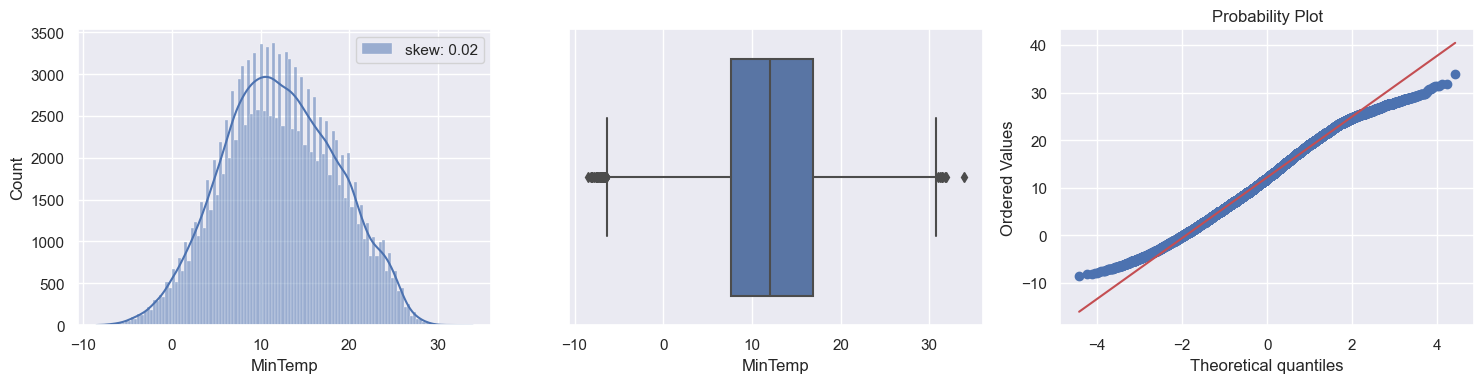

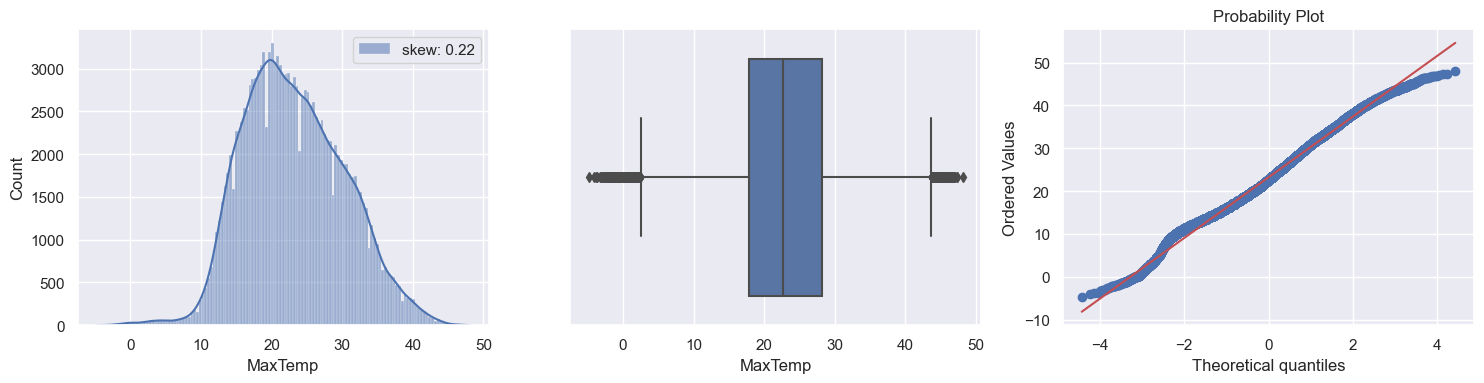

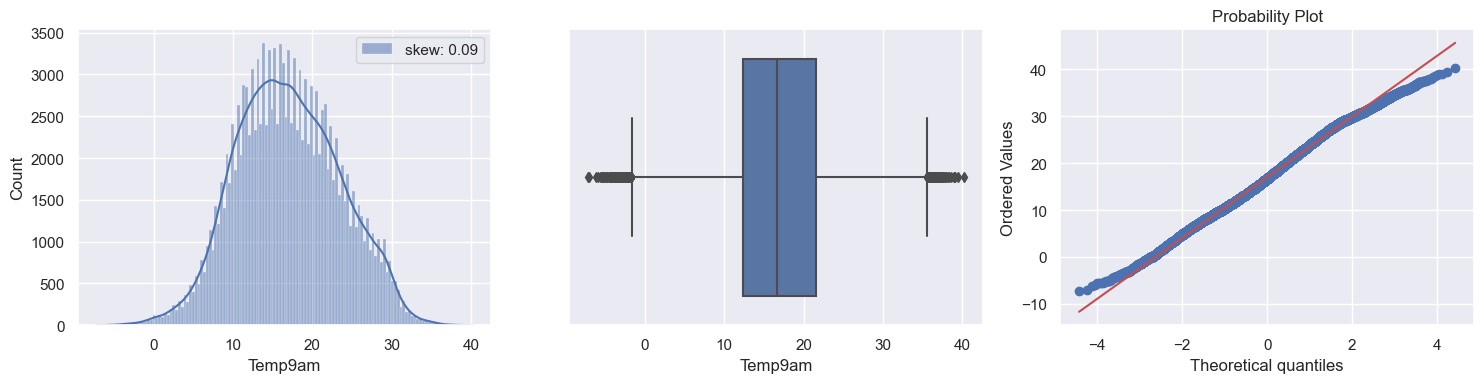

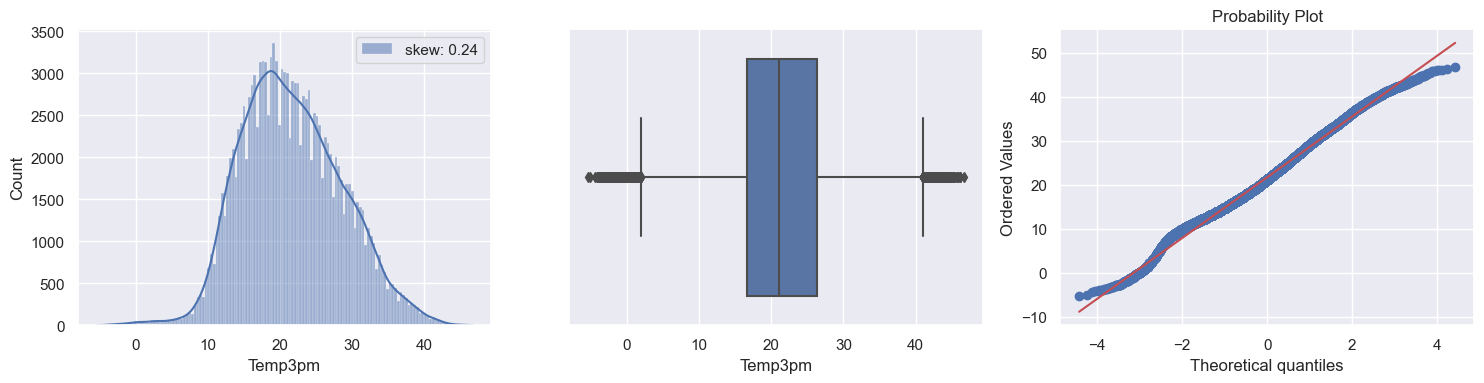

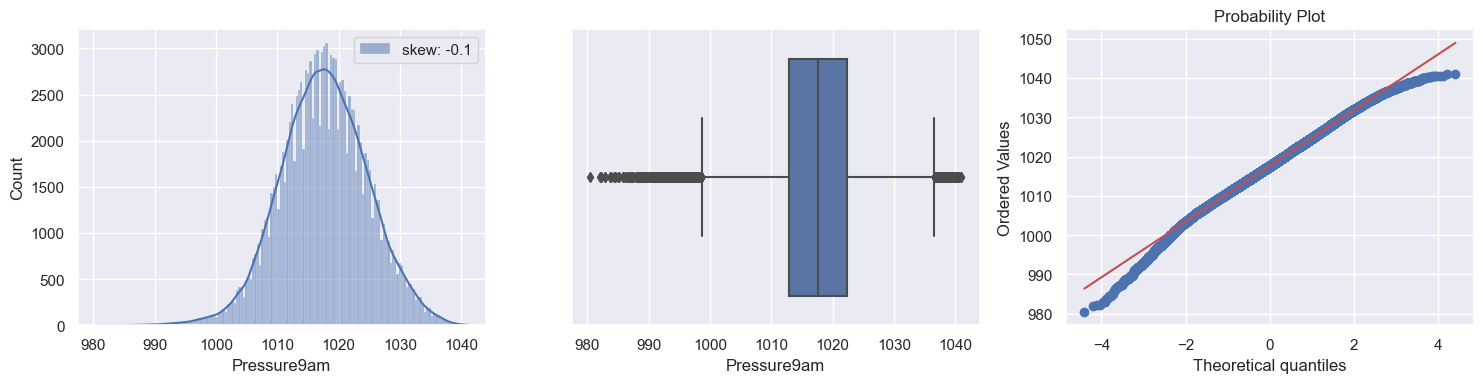

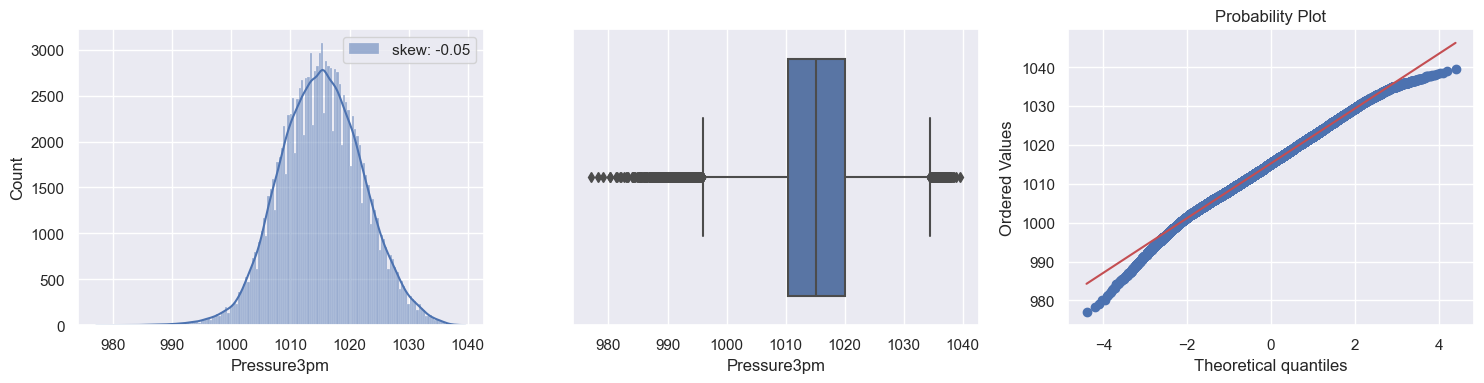

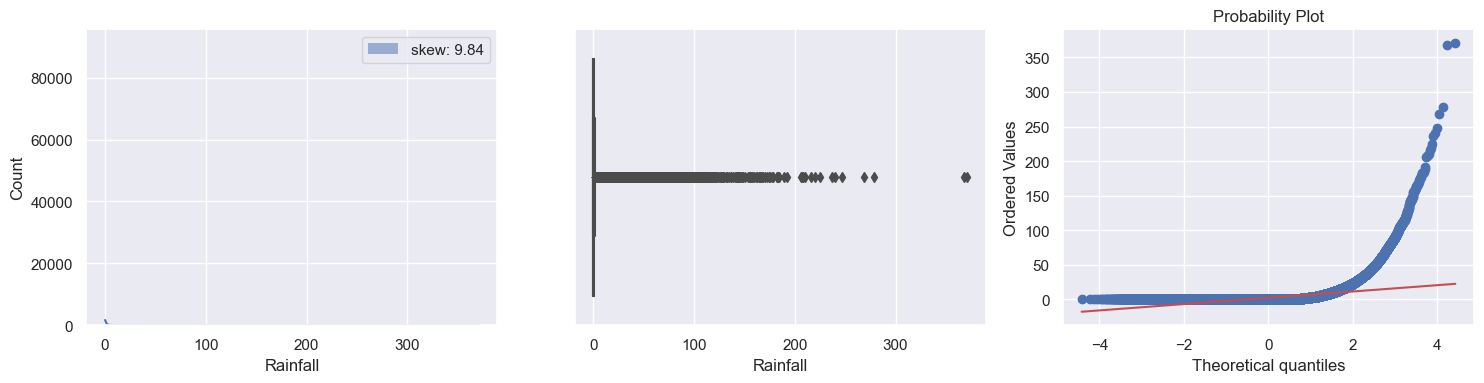

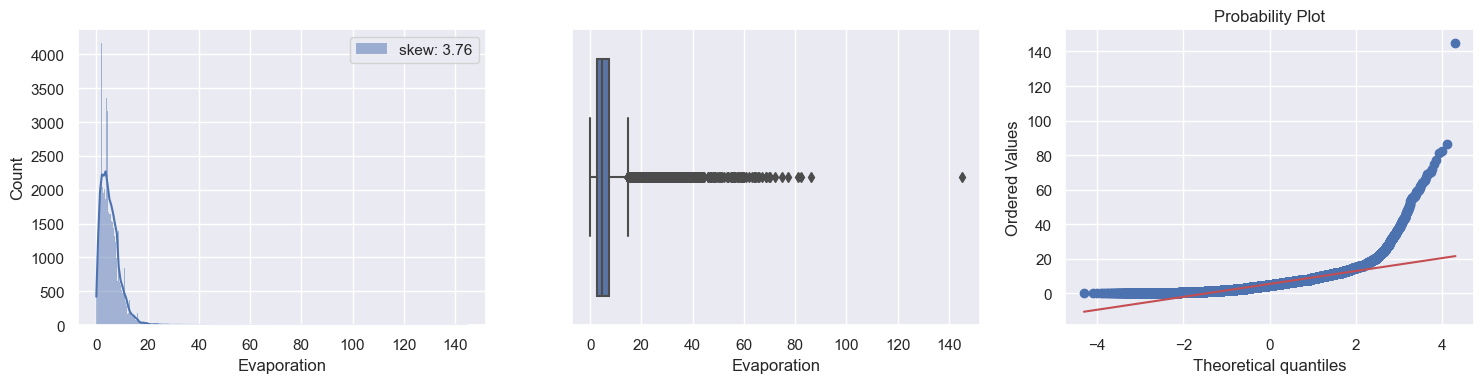

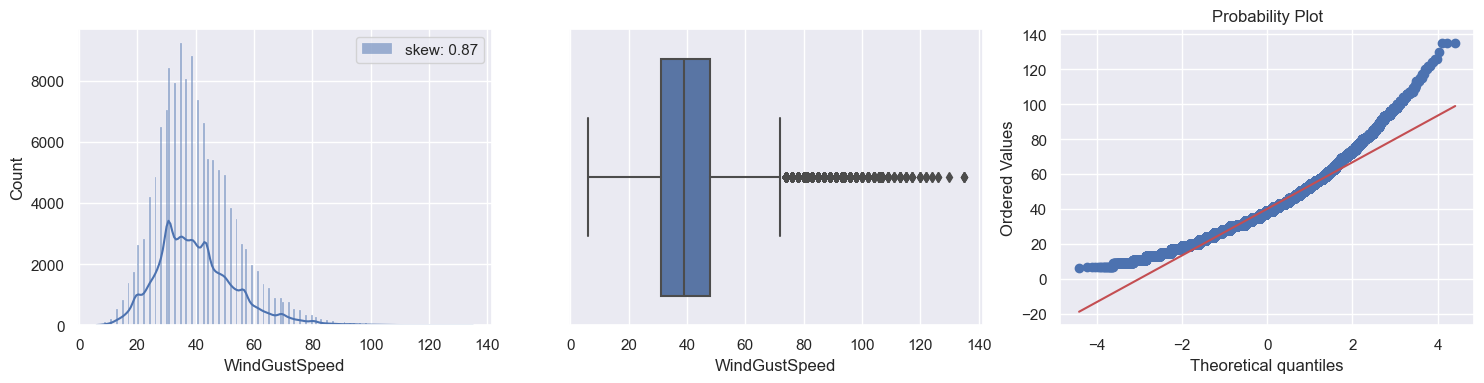

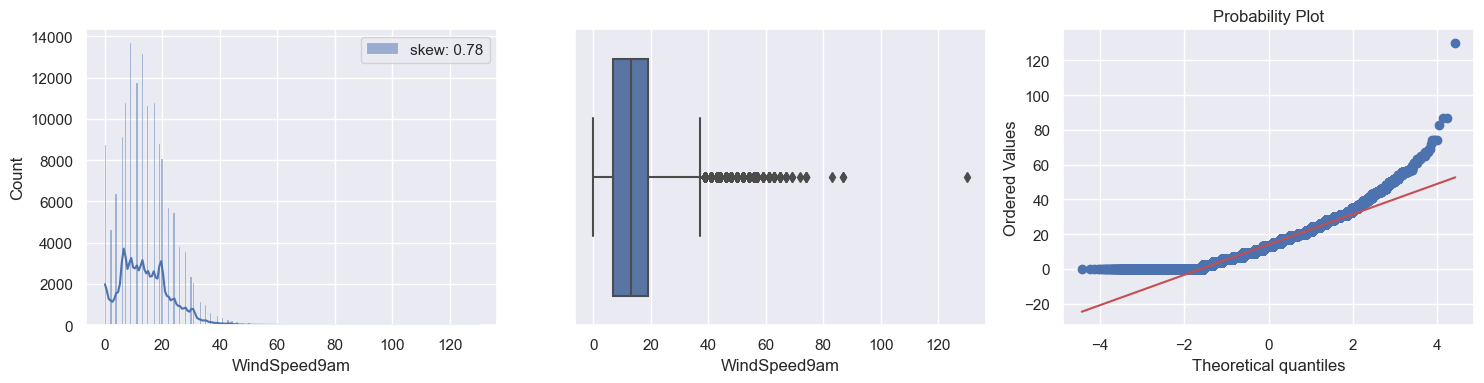

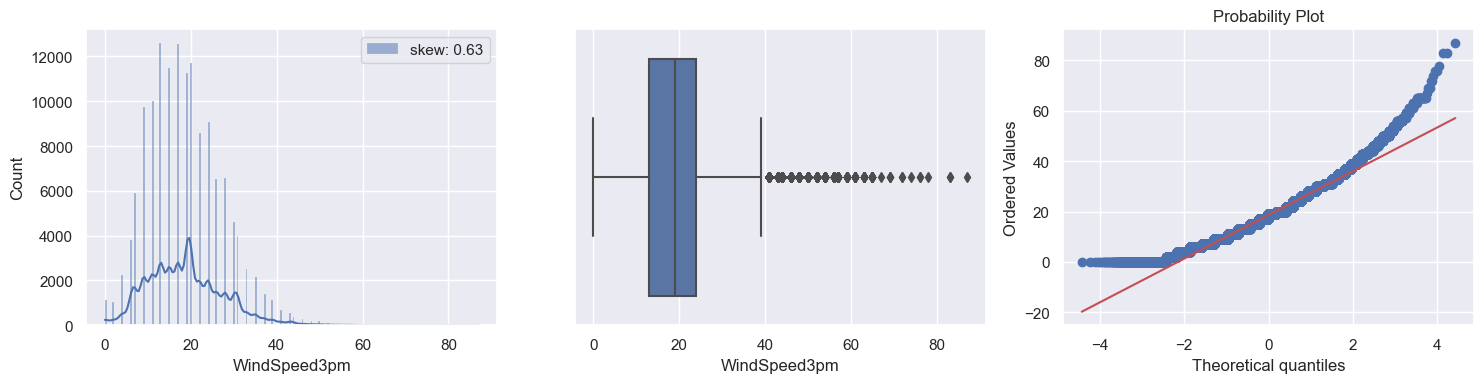

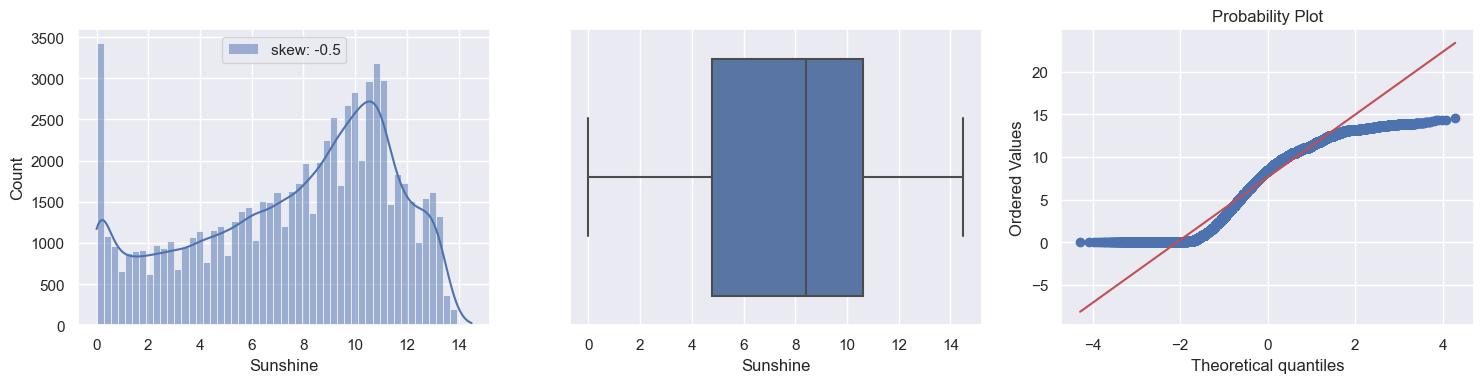

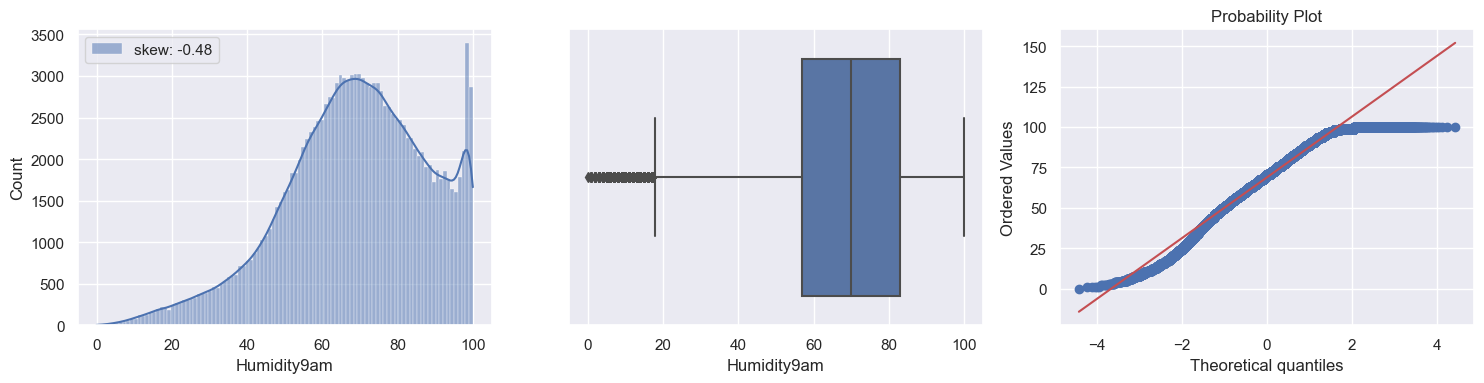

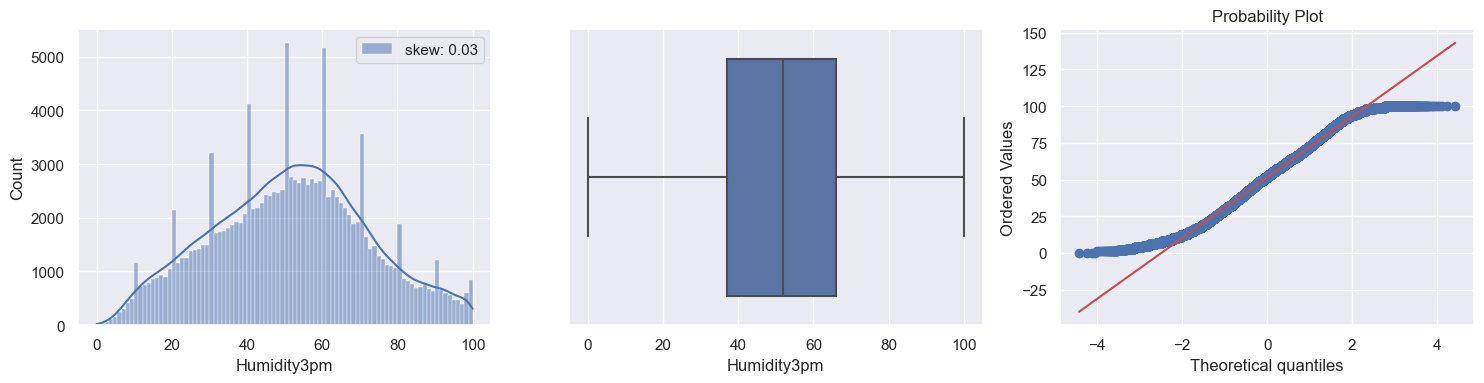

In [105]:
features = ["MinTemp","MaxTemp", "Temp9am", "Temp3pm", "Pressure9am", "Pressure3pm", "Rainfall", "Evaporation", "WindGustSpeed", "WindSpeed9am", "WindSpeed3pm", "Sunshine", "Humidity9am", "Humidity3pm"]
display_dataset_distributions (df, features)

**Observaciones:**
* El valor de skew para las variables MinTemp, MaxTemp, Temp9am, Temp3pm, Pressure9am y Pressure3pm es bastante bajo.
* El gráfico Q-Q plot muestra que las variables, MinTemp, MaxTemp, Temp9am, Temp3pm, Pressure9am y Pressure3pm podrían asumirse con distribución normal, sin embargo se observa que las colas se separan bastante. Es probable que existan outliers en ambos lados de las colas.
* Las variable Rainfall, Evaporation, WindGustSpeed, WindSpeed9am, WindSpeed3pm, Sunshine, Humidity9am, Humidity3pm no muestran una distribución normal.

In [289]:
def display_dataset_distributions_transf (df, features, qt):
    for col in features:
        df_aux = df[df[col].notnull()][col].to_numpy()
        df_aux = df_aux.reshape((len(df_aux),1))
        df_aux = qt.fit(df_aux).transform(df_aux)
        df_aux.reshape((1,-1))[0]

        fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(15, 4))
        sns.histplot(data=df_aux,kde=True, ax=axs[0])

        axs[0].set_ylabel('Count')
        fig.suptitle(col, fontsize=12)

        sns.boxplot(x=df_aux, ax=axs[1])
        stats.probplot(df_aux.reshape((1,-1))[0], plot=axs[2])

        plt.show()

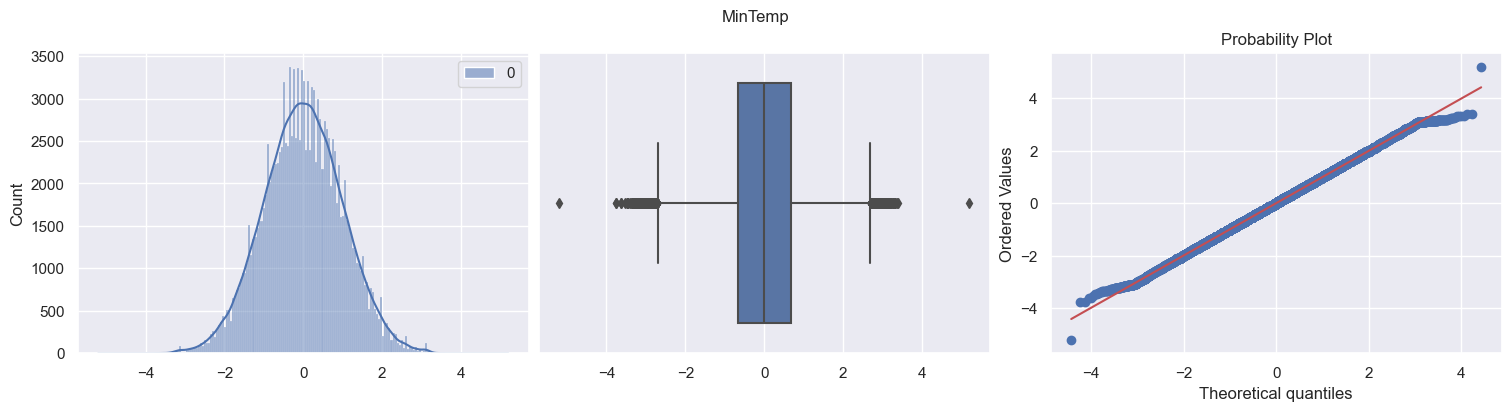

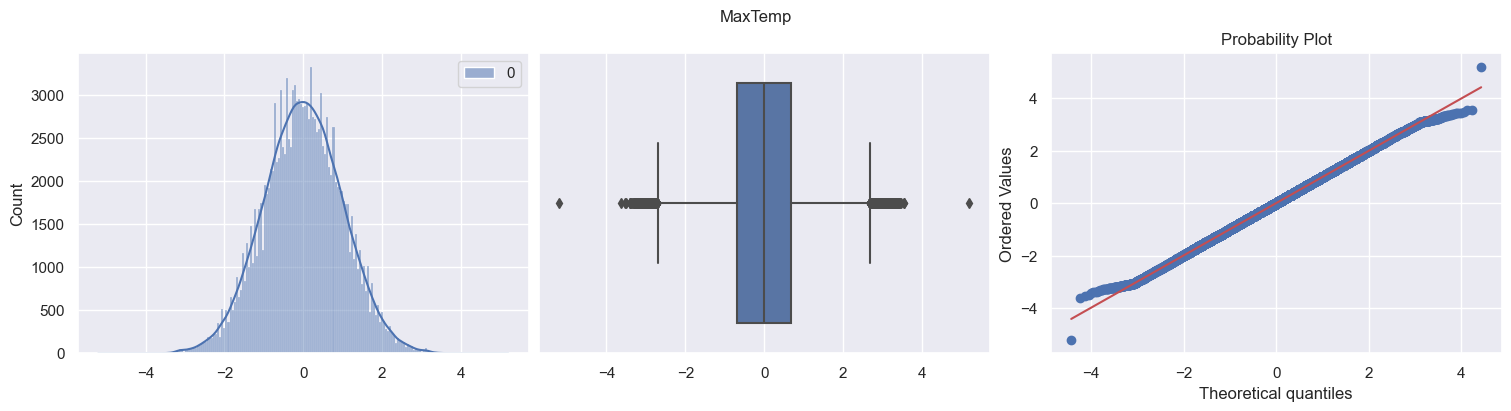

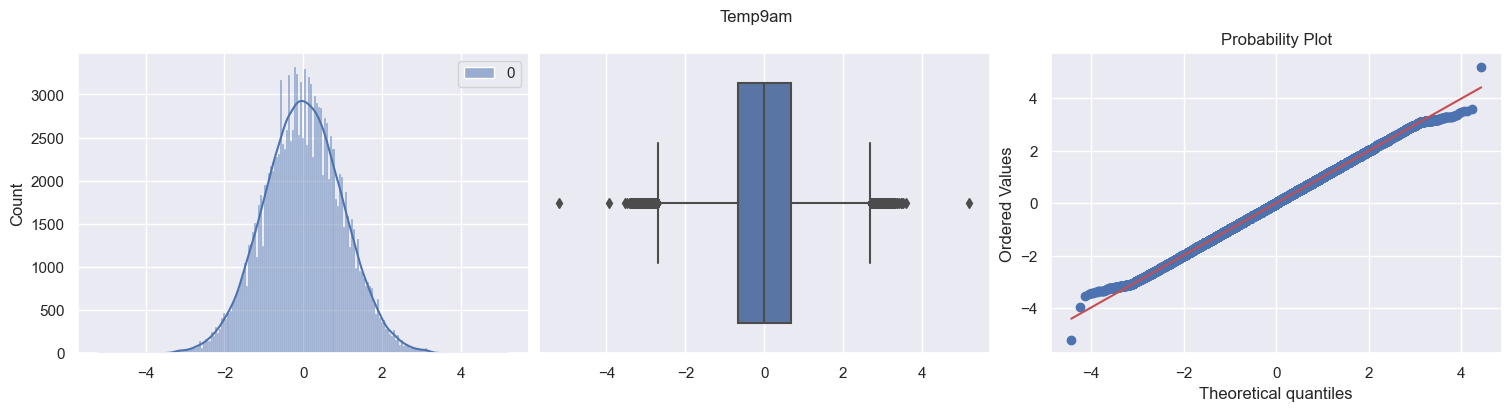

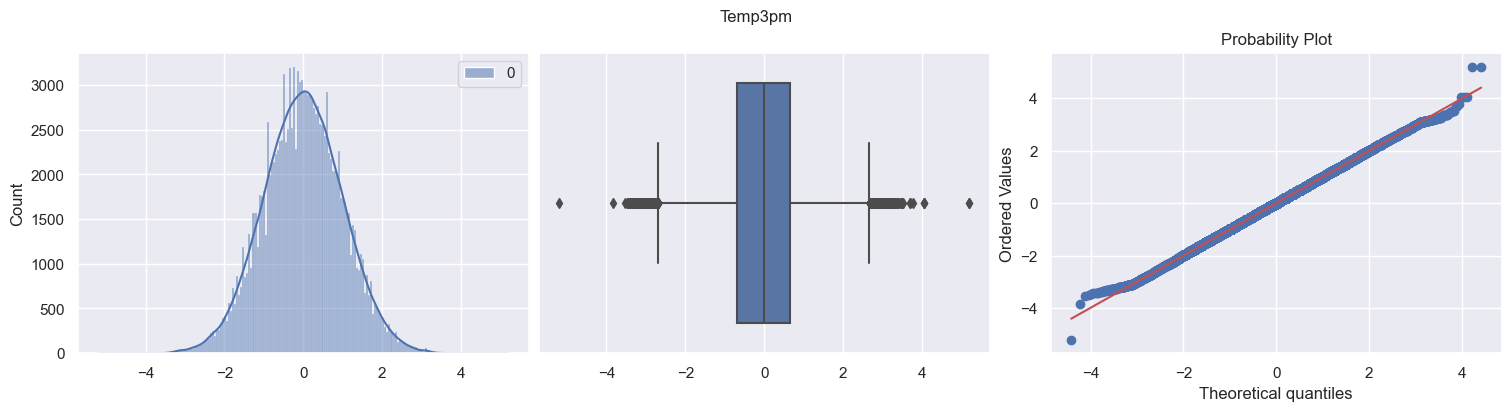

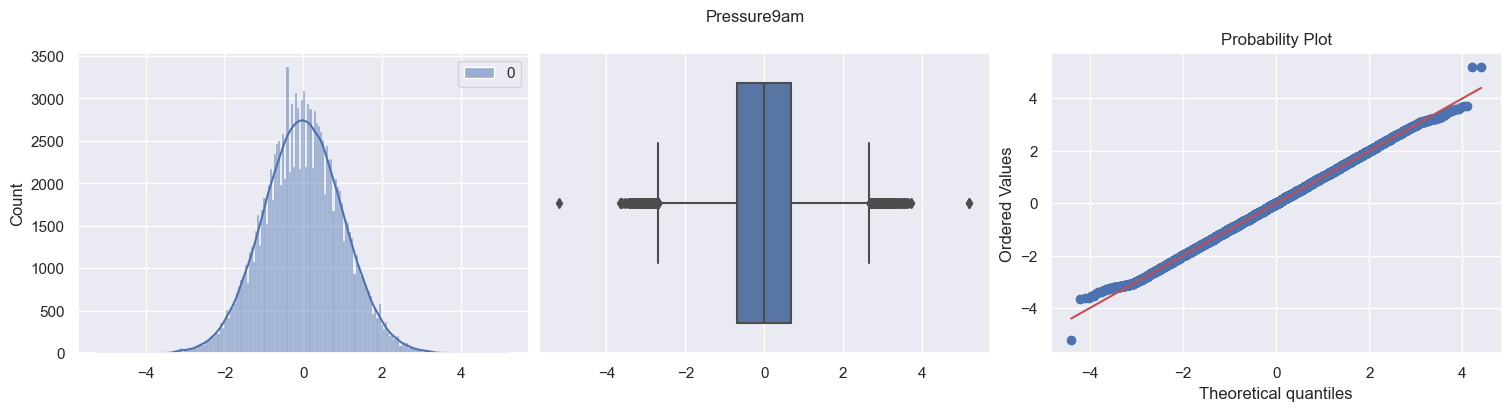

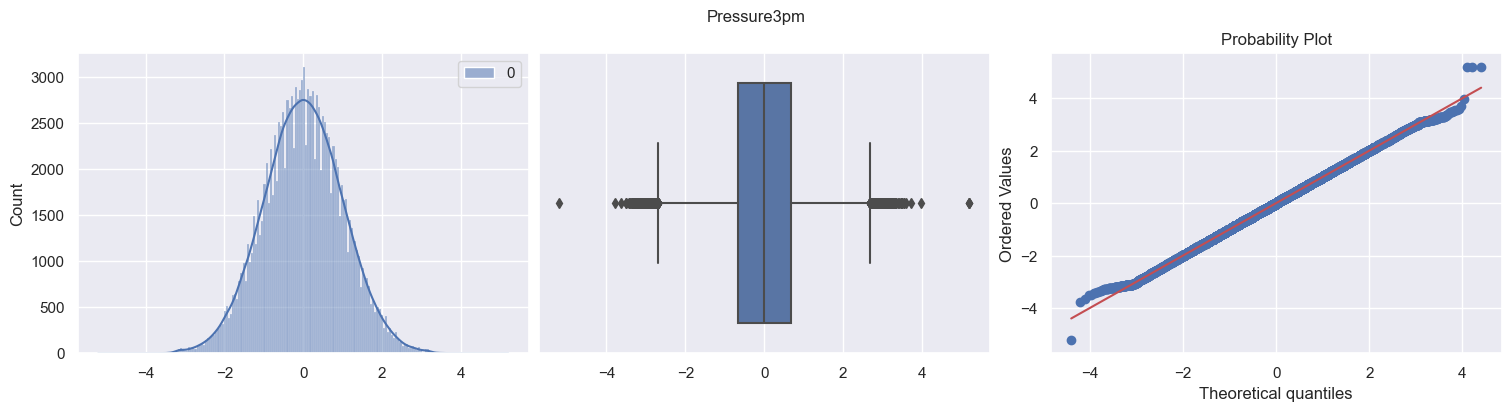

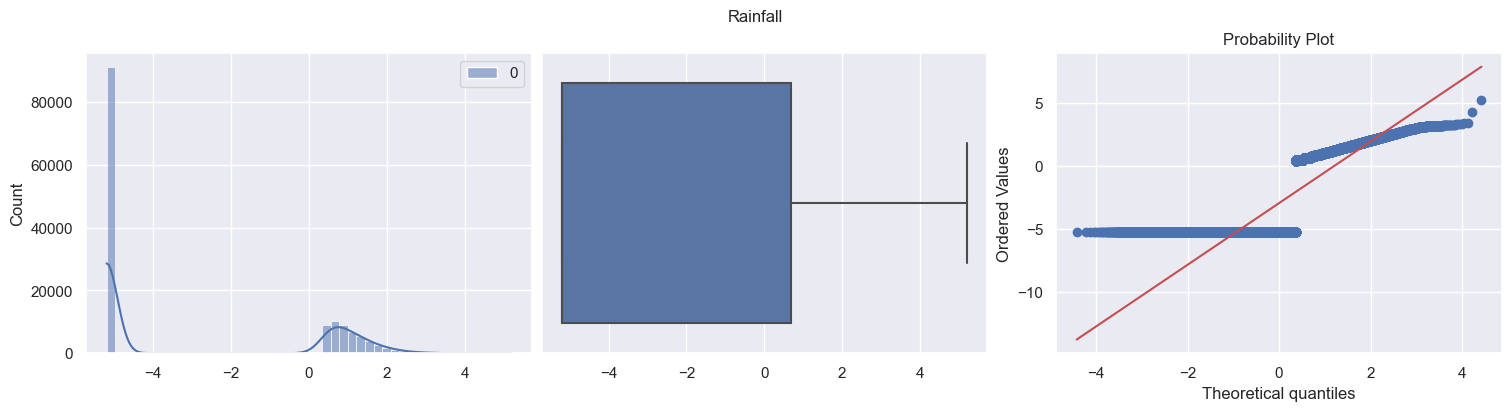

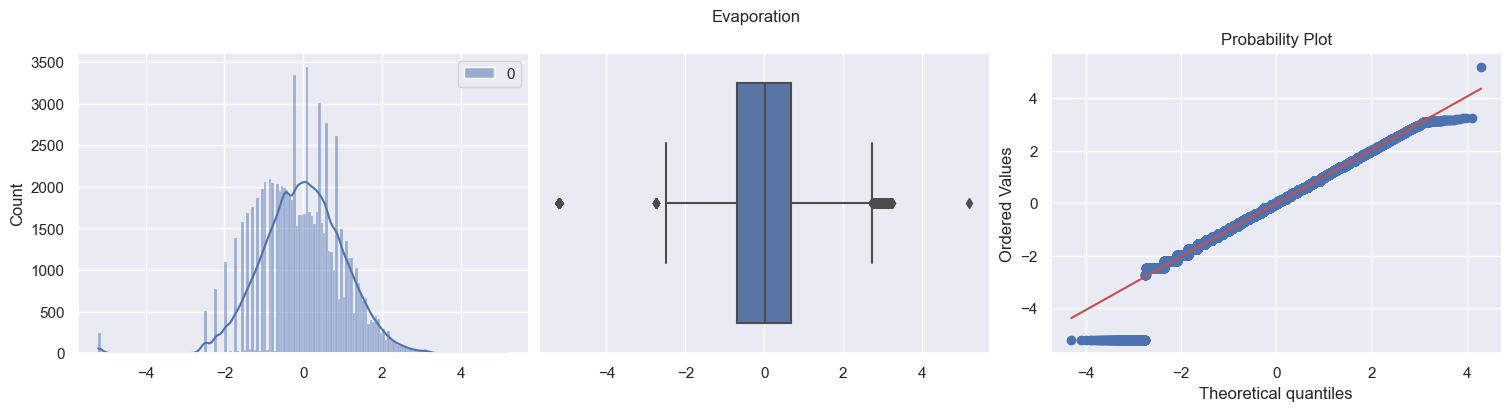

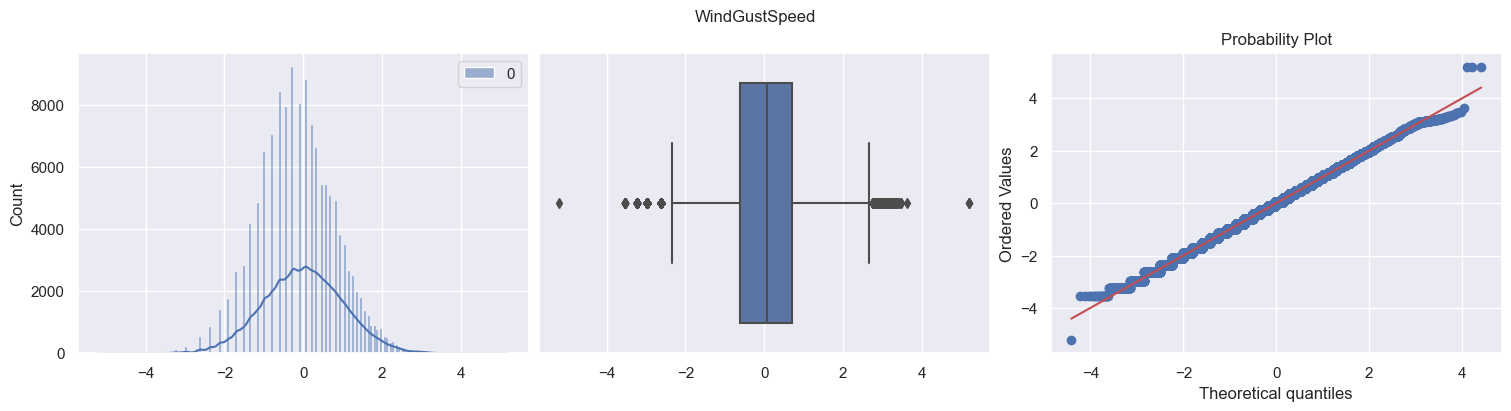

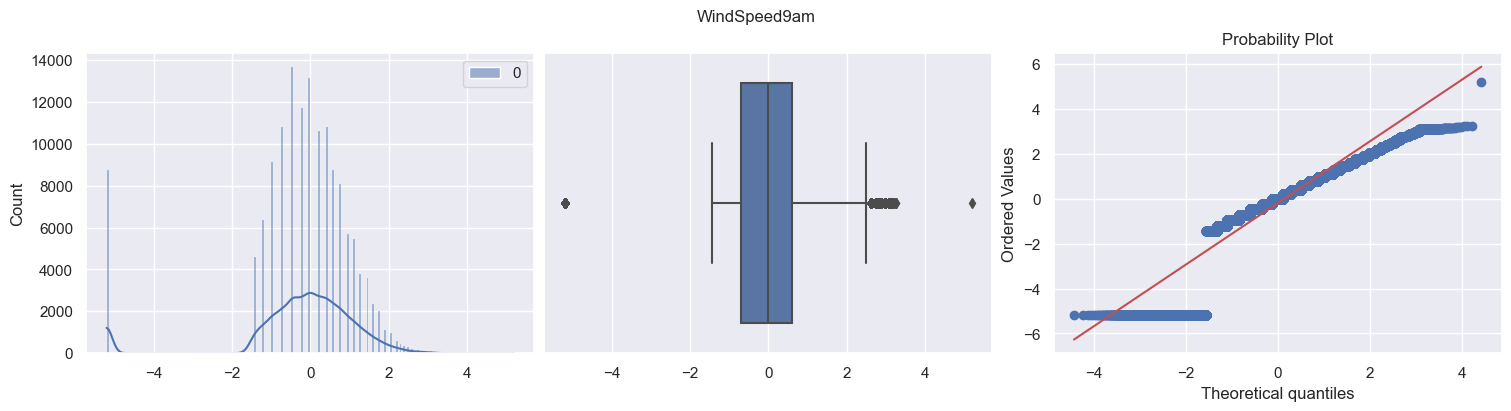

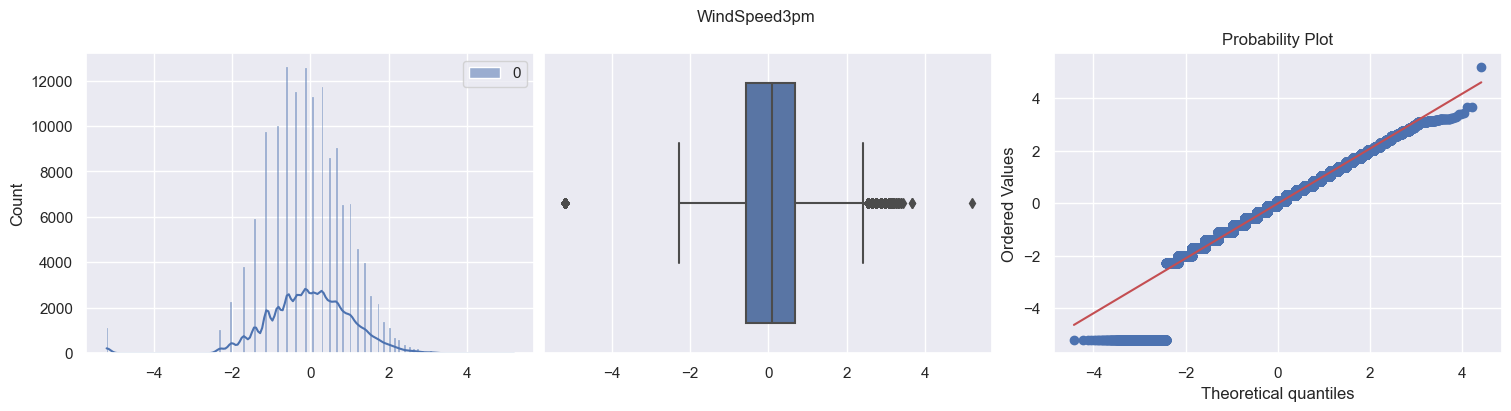

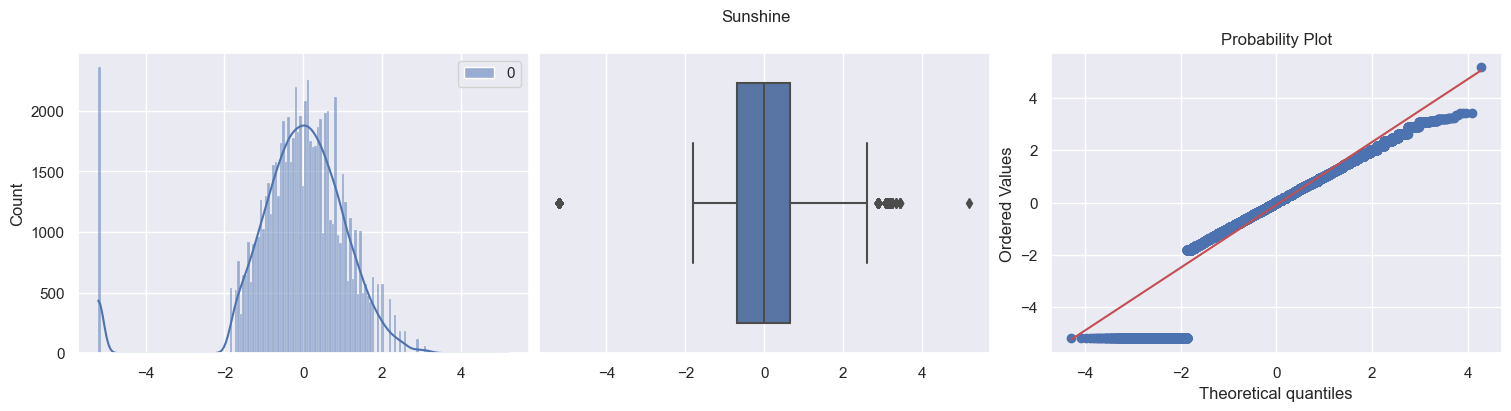

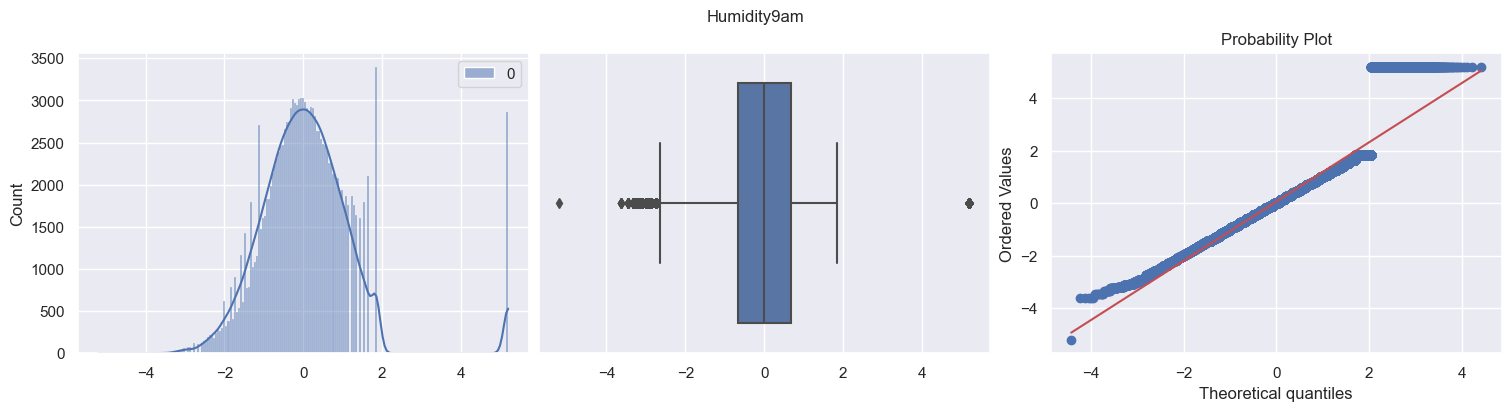

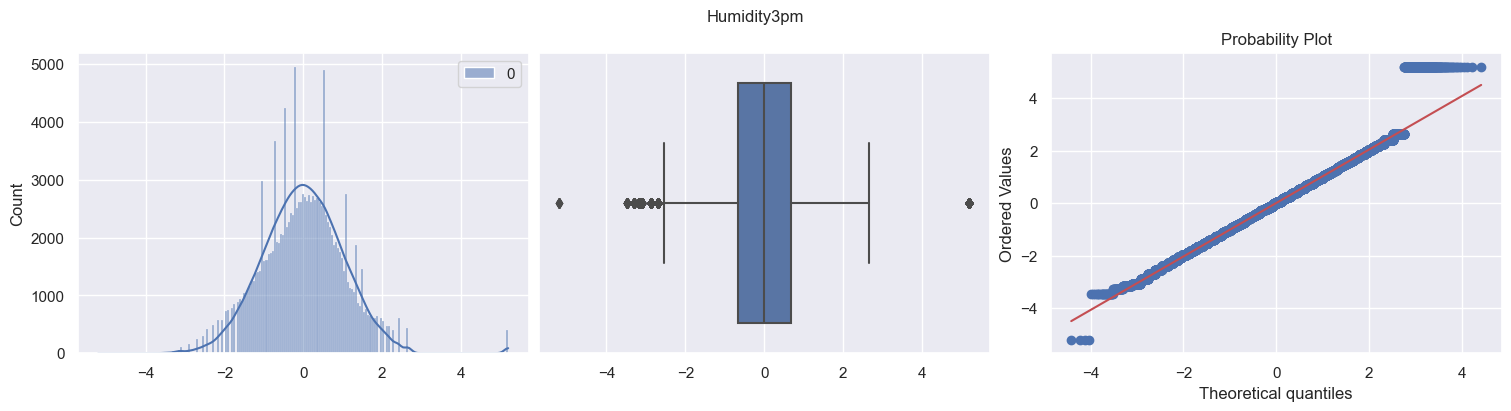

In [290]:
features = ["MinTemp","MaxTemp", "Temp9am", "Temp3pm", "Pressure9am", "Pressure3pm", "Rainfall", "Evaporation", "WindGustSpeed", "WindSpeed9am", "WindSpeed3pm", "Sunshine", "Humidity9am", "Humidity3pm"]
qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=rng)
display_dataset_distributions_transf (df, features, qt)

## Análisis de outliers:

In [291]:
df_aux = pd.DataFrame( df[df["Sunshine"].notnull()]["Sunshine"] )
Q1 = df_aux.quantile(0.25)
Q3 = df_aux.quantile(0.75)
IQR = Q3 - Q1
df_aux = df_aux[~((df_aux < (Q1 - 1.5 * IQR)) |(df_aux > (Q3 + 1.5 * IQR))).any(axis=1)]

def busco_outliers(df, features):
    for col in features:
        IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
        limite_inferior = df.features.quantile(0.25) - (IQR * 3)
        limite_superior = df.features.quantile(0.75) + (IQR * 3)
        print(col +' outliers: < {limite_inferior} or > {limite_superior}'.format(limite_inferior=limite_inferior, limite_superior=limite_superior))

AttributeError: 'numpy.ndarray' object has no attribute 'quantile'

In [ ]:
features = ["MinTemp","MaxTemp", "Temp9am", "Temp3pm", "Pressure9am", "Pressure3pm", "Rainfall", "Evaporation", "WindGustSpeed", "WindSpeed9am", "WindSpeed3pm", "Sunshine", "Humidity9am", "Humidity3pm"]
busco_outliers(df, features)

## Análisis de correlación entre variables de entrada:

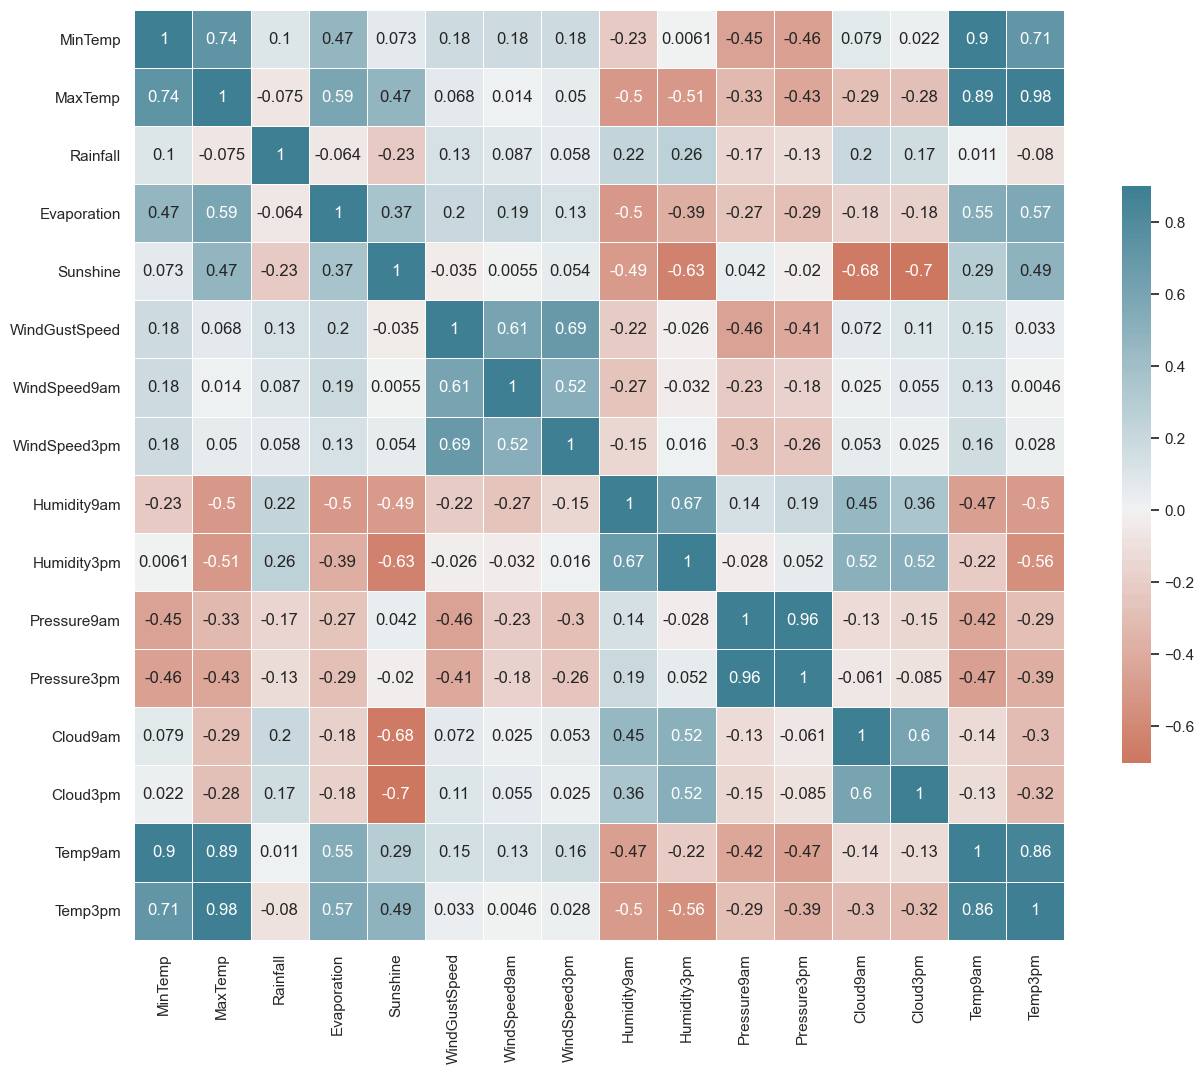

In [292]:
fig = plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), cmap=sns.diverging_palette(20, 220, n=200), vmax=.9, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
plt.show()

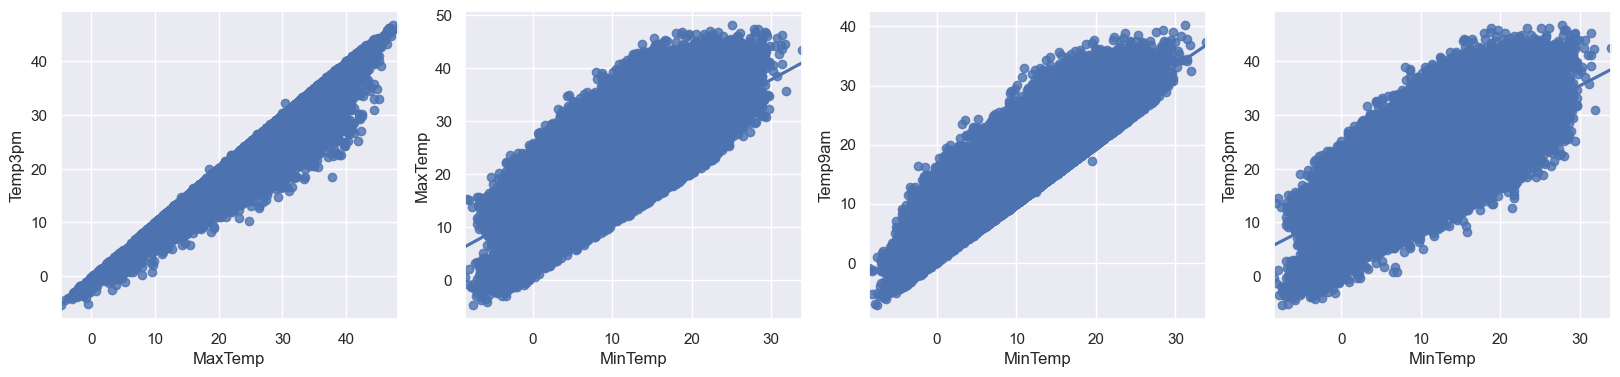

In [293]:
fig,axes = plt.subplots(1,4,figsize=(20,4))
sns.regplot(x="MaxTemp", y="Temp3pm", data=df, order=1,ax=axes[0])
sns.regplot(x="MinTemp", y="MaxTemp", data=df, order=1,ax=axes[1])
sns.regplot(x="MinTemp", y="Temp9am", data=df, order=1,ax=axes[2])
sns.regplot(x="MinTemp", y="Temp3pm", data=df, order=1,ax=axes[3])
plt.show()

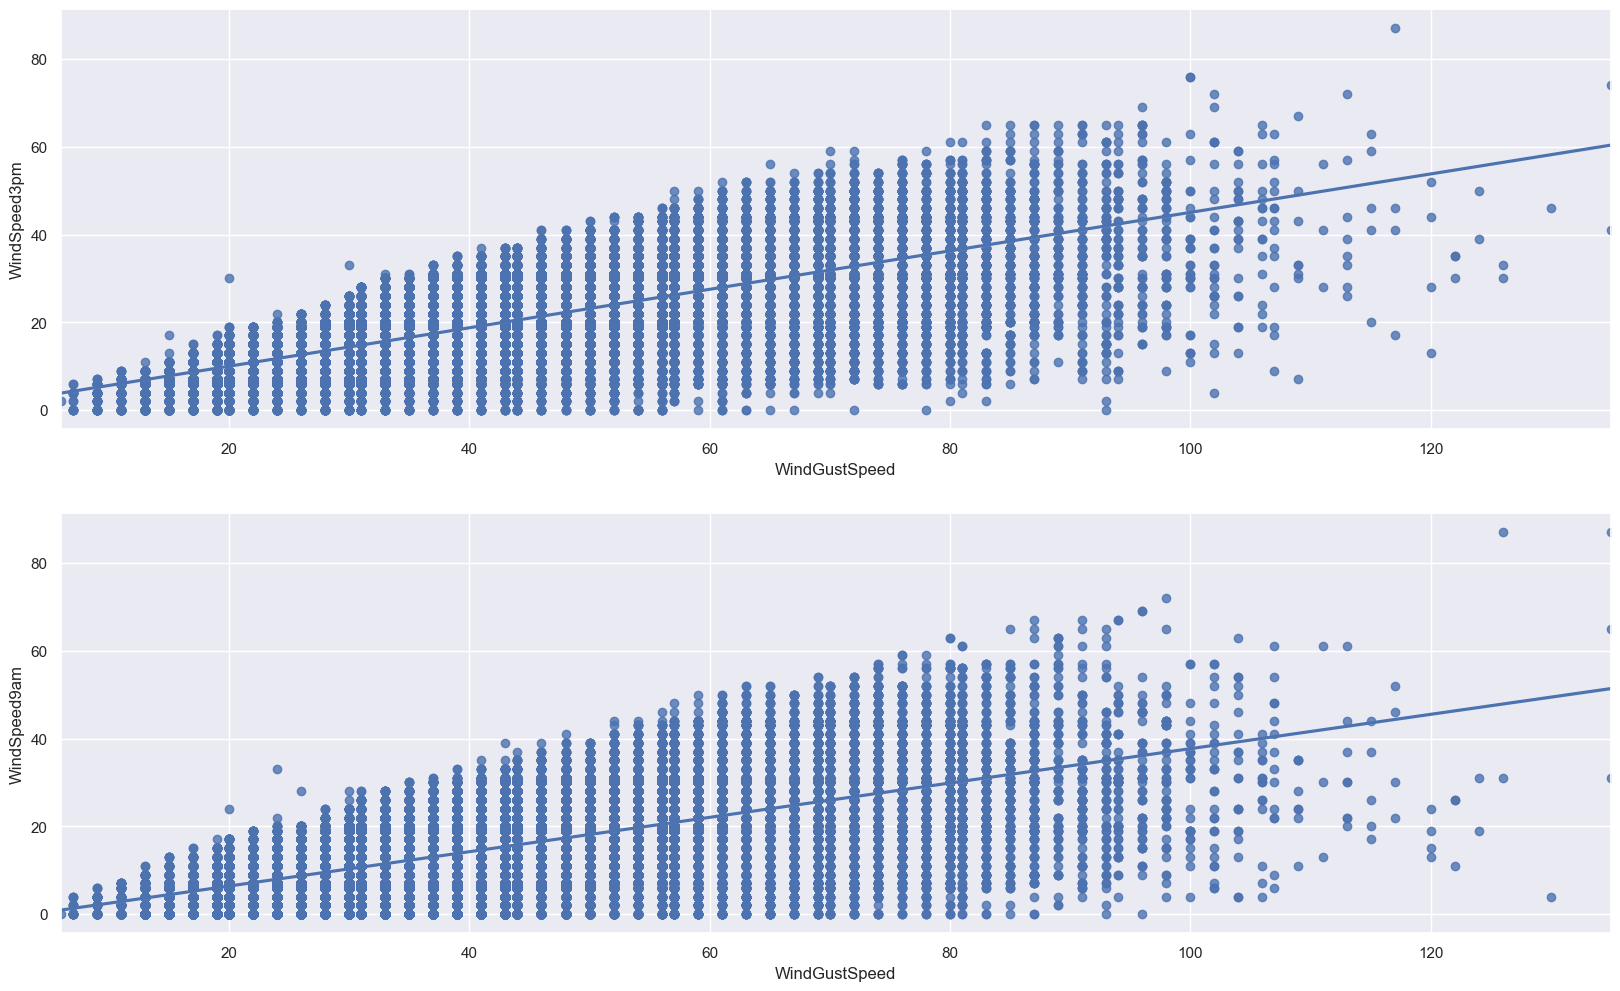

In [294]:
fig,axes = plt.subplots(2,1,figsize=(20,12))
sns.regplot(x="WindGustSpeed", y="WindSpeed3pm", data=df, order=1,ax=axes[0])
sns.regplot(x="WindGustSpeed", y="WindSpeed9am", data=df, order=1,ax=axes[1])
plt.show()

**Observaciones:**
* Existe una fuerte correlación entre las variables MinTemp, MaxTemp, Temp9am, Temp3pm.
* Existe una fuerte correlación entre las variables WindGustSpeed, WindSpeed3pm y WindSpeed9am.
* Exiset una fuerte correlación entre las variables Sunshine y las variablas Humidity3pm y Humidity9am.
* Exiset una fuerte correlación entre las variables Sunshine y las variablas Cloud9am y Cloud3pm.
* Existe una fuerta correlación entre las variables Pressure9am y Pressure3pm.

## Análisis de correlación entre variables y variable de salida:

### Temperatura vs RainTomorrow:

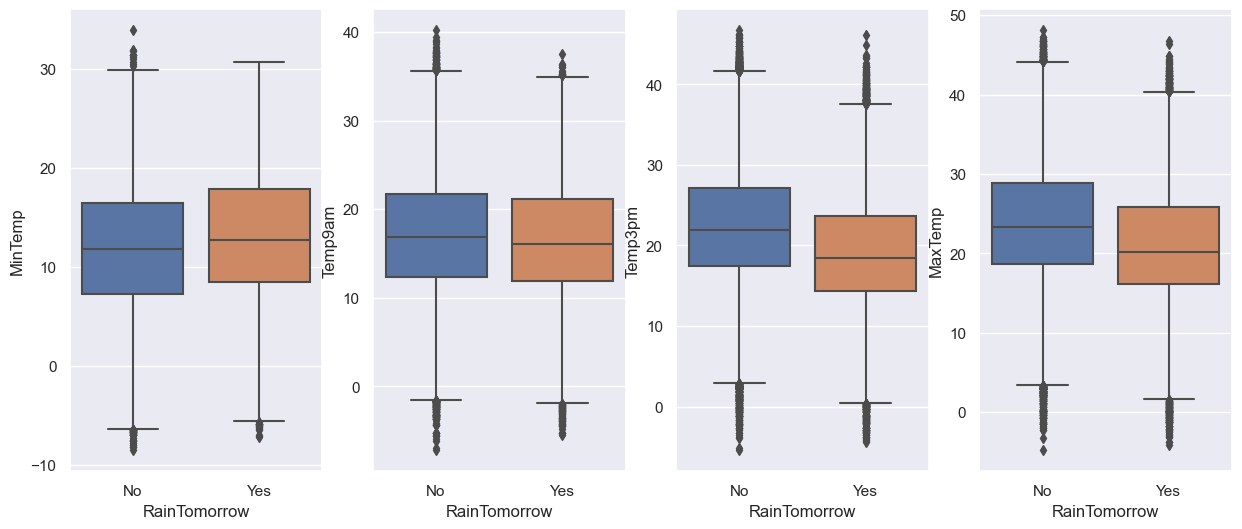

In [342]:
fig, axes = plt.subplots(1, 4, figsize=(15, 6))

sns.boxplot(x="RainTomorrow", y='MinTemp', data=df, ax=axes[0])
sns.boxplot(x="RainTomorrow", y='Temp9am', data=df, ax=axes[1])
sns.boxplot(x="RainTomorrow", y='Temp3pm', data=df, ax=axes[2])
sns.boxplot(x="RainTomorrow", y='MaxTemp', data=df, ax=axes[3])
plt.show()


**Se observa que a las variables Temp3pm y MaxTemp son las que mayor efecto tienen sobre la variable de salida RainTomorrow**

### Velocidad del viento vs RainTomorrow:     

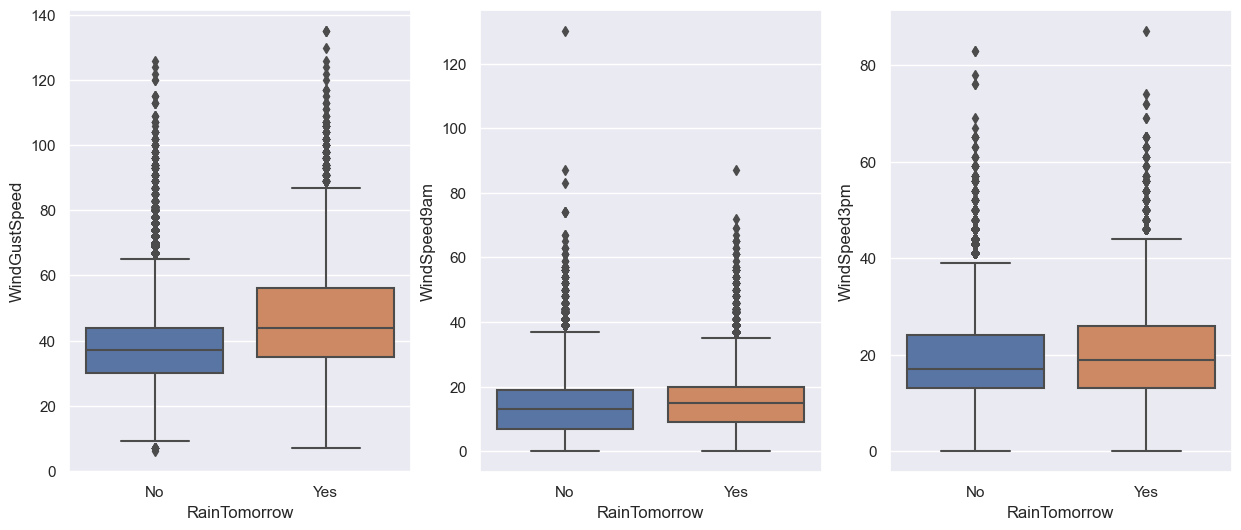

In [345]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

sns.boxplot(x="RainTomorrow", y='WindGustSpeed', data=df, ax=axes[0])
sns.boxplot(x="RainTomorrow", y='WindSpeed9am', data=df, ax=axes[1])
sns.boxplot(x="RainTomorrow", y='WindSpeed3pm', data=df, ax=axes[2])
plt.show()

**Se observa que a la variables WindGustSpeed es la que mayor efecto tienen sobre la variable de salida RainTomorrow**

### Dirección del viento vs RainTomorrow:

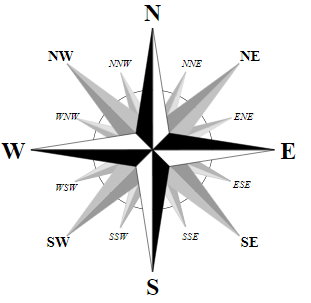

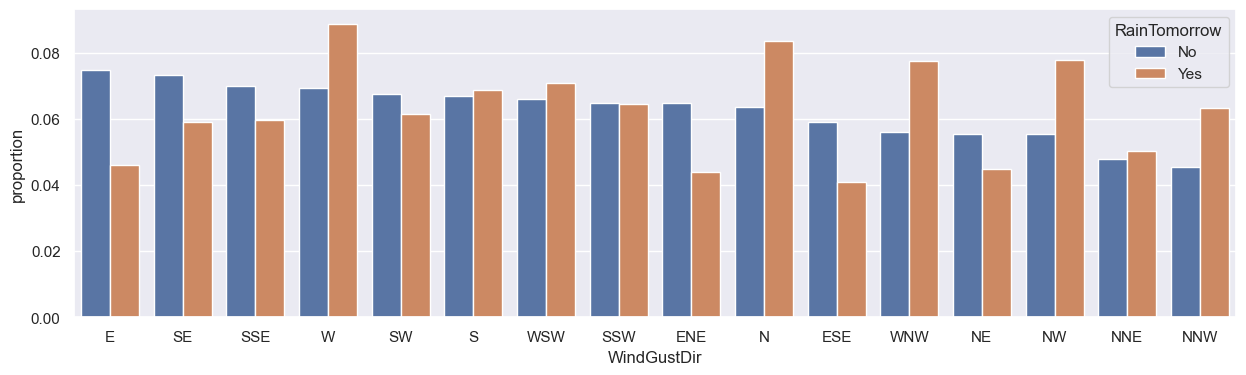

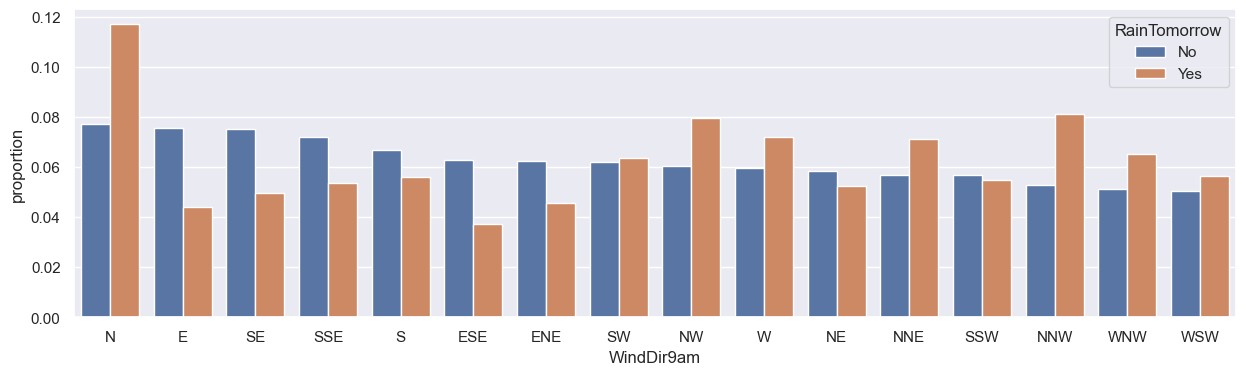

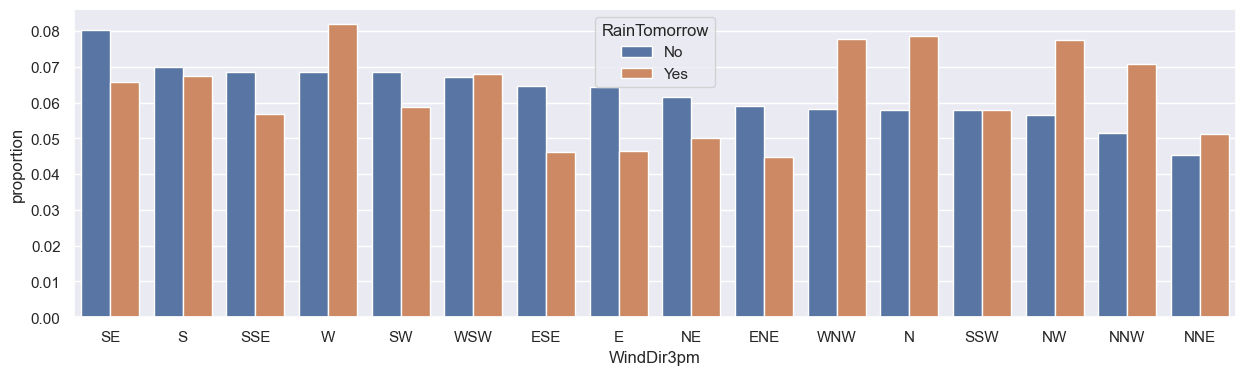

In [79]:
fig, axes = plt.subplots(1, 1, figsize=(15, 4))
x, y, hue = "WindGustDir", "proportion", "RainTomorrow"
df_aux = (df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index())

ax = sns.barplot(x="WindGustDir", y="proportion", data=df_aux, hue="RainTomorrow")
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(15, 4))
x, y, hue = "WindDir9am", "proportion", "RainTomorrow"
df_aux = (df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index())

ax = sns.barplot(x="WindDir9am", y="proportion", data=df_aux, hue="RainTomorrow")
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(15, 4))
x, y, hue = "WindDir3pm", "proportion", "RainTomorrow"
df_aux = (df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index())

ax = sns.barplot(x="WindDir3pm", y="proportion", data=df_aux, hue="RainTomorrow")
plt.show()

**Se observa una fuerte relación entre la dirección del viento y la probabilidad de lluvia. Cuando los vientos provienten entre el norte y el oeste (N, NNW, NW, WNW y W) existe una mayor probabilidad de lluvia.**

## Análisis de variables categóricas de entrada:
* Date           
* Location       
* WindGustDir
* WindDir9am 
* WindDir3pm    
* RainToday  
* RainTomorrow  

In [310]:
# Analizamos las variables categoricas:
df.describe(include='object')

,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
count,145460,135134,134894,141232,142199,142193
unique,49,16,16,16,2,2
top,Canberra,W,N,SE,No,No
freq,3436,9915,11758,10838,110319,110316


In [311]:
print(df.Location.unique())
print("Cardinalidad: ", len(df.Location.unique()))

['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru']
Cardinalidad:  49


In [312]:
print(df.WindGustDir.unique())
print("Cardinalidad: ", len(df.WindGustDir.unique()))

['W' 'WNW' 'WSW' 'NE' 'NNW' 'N' 'NNE' 'SW' nan 'ENE' 'SSE' 'S' 'NW' 'SE'
 'ESE' 'E' 'SSW']
Cardinalidad:  17


In [313]:
print(df.WindDir9am.unique())
print("Cardinalidad: ", len(df.WindDir9am.unique()))

['W' 'NNW' 'SE' 'ENE' 'SW' 'SSE' 'S' 'NE' nan 'SSW' 'N' 'WSW' 'ESE' 'E'
 'NW' 'WNW' 'NNE']
Cardinalidad:  17


In [314]:
print(df.WindDir3pm.unique())
print("Cardinalidad: ", len(df.WindDir3pm.unique()))

['WNW' 'WSW' 'E' 'NW' 'W' 'SSE' 'ESE' 'ENE' 'NNW' 'SSW' 'SW' 'SE' 'N' 'S'
 'NNE' nan 'NE']
Cardinalidad:  17


In [315]:
print(df.Cloud9am.unique())
print("Cardinalidad: ", len(df.Cloud9am.unique()))

[ 8. nan  7.  1.  0.  5.  4.  2.  6.  3.  9.]
Cardinalidad:  11


In [316]:
print(df.Cloud3pm.unique())
print("Cardinalidad: ", len(df.Cloud3pm.unique()))

[nan  2.  8.  7.  1.  5.  4.  6.  3.  0.  9.]
Cardinalidad:  11


In [317]:
print(df.RainToday.unique())
print("Cardinalidad: ", len(df.RainToday.unique()))

['No' 'Yes' nan]
Cardinalidad:  3


In [318]:
print(df.RainTomorrow.unique())
print("Cardinalidad: ", len(df.RainTomorrow.unique()))

['No' 'Yes' nan]
Cardinalidad:  3


**Observaciones:**
* Exiten presentes 8 variables categoricas.
* 6 de las 8 variables son nominales.
* Las variables Cloud9am y Cloud3pm son ordinales.
* La variable Location posee 49 categorías e identifican nombres puntos de locación en la cual se realizaron las mediciones.
* Las variables WindGustDir, WindDir3pm y WindDir9am  poseen 17 categorías las cuales son iguales las cuales son códigos que describen puntos cardinales de dirección del viento.
* Las variables Cloud9am y Cloud3pm poseen 10 categorías.
* La variable RainToday y RainTomorrow poseen dos categorías.
* La variable RainTomorrow es la variable de salida u objetivo.

### Location:

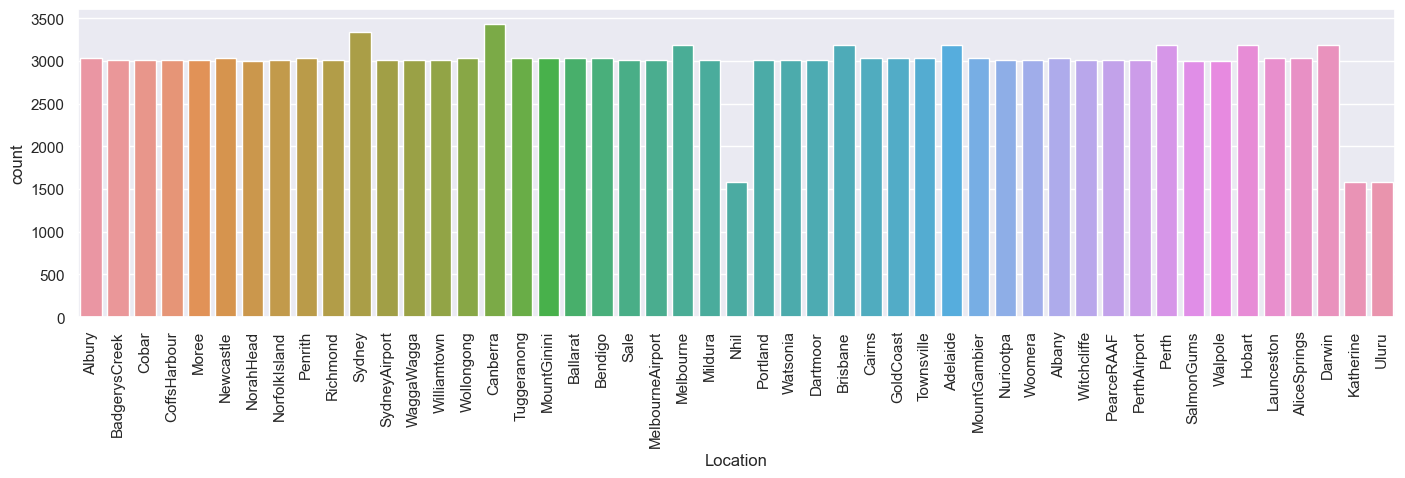

In [346]:
figure(figsize=(17,4))
plt.xticks(rotation=90)
sns.countplot(x=df['Location'])
plt.show()

**Observaciones:**
* La variable Location posee 49 caegórias. Esta variable presenta una cardinalidad alta.
* Se observa que la distribución de los datos es uniforme para todas las locaciones.

### Dirección de viento:

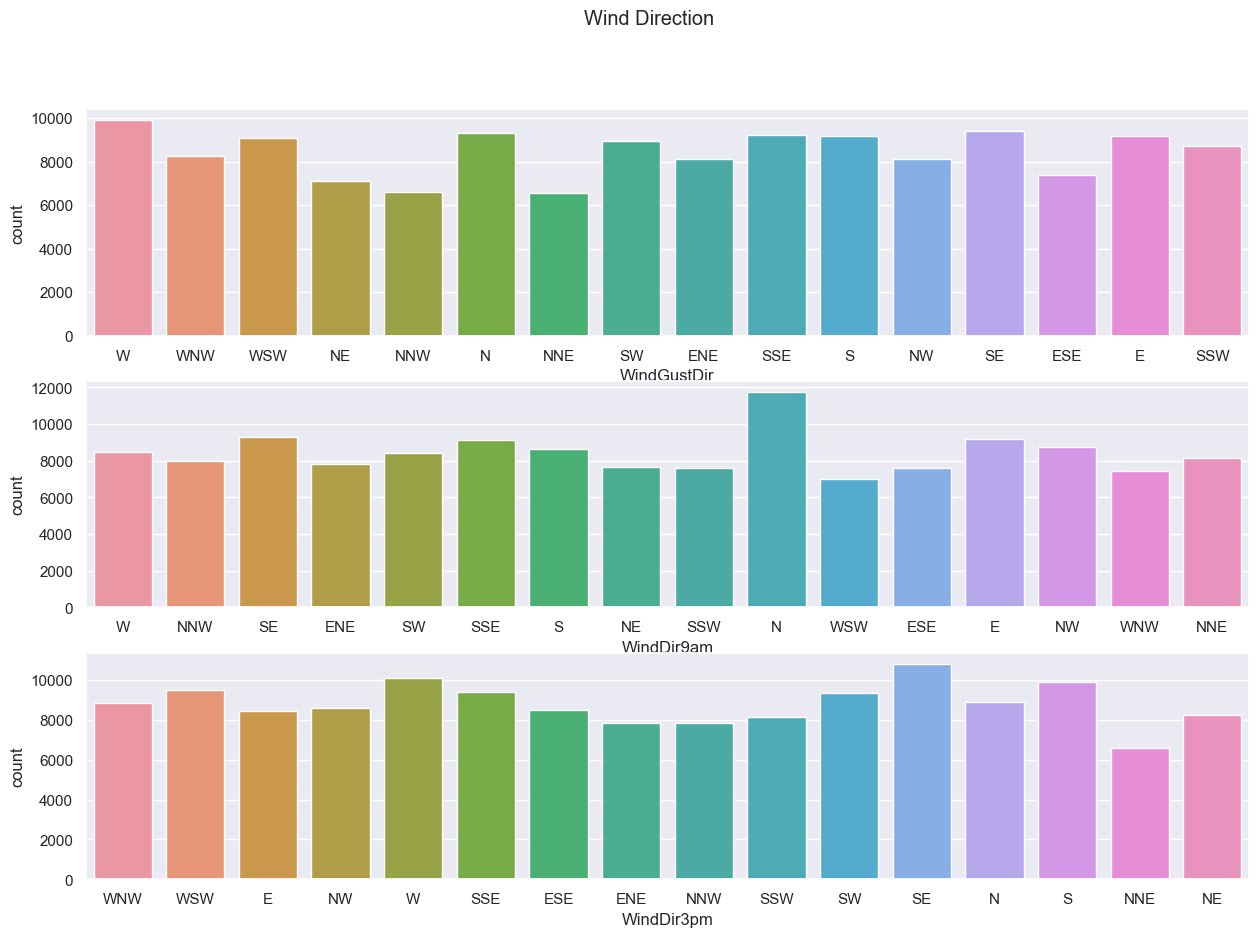

In [347]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10))
fig.suptitle('Wind Direction')
sns.countplot(ax=axes[0], x=df['WindGustDir'])
sns.countplot(ax=axes[1], x=df['WindDir9am'])
sns.countplot(ax=axes[2], x=df['WindDir3pm'])
plt.show()

**Observaciones:**
* Las variables de dirección del viento poseen 17 categórias que representan diferentes direcciones en el sistema de coordenadas cartesiano, podemos pensar en agrupar estas 17 variables en solo 4 principales (N, S, E, W).
* Se observa que la dirección del viento a las 9:00 am es principalmente desde el norte y a las 3:00 pm del sureste.

### Date:

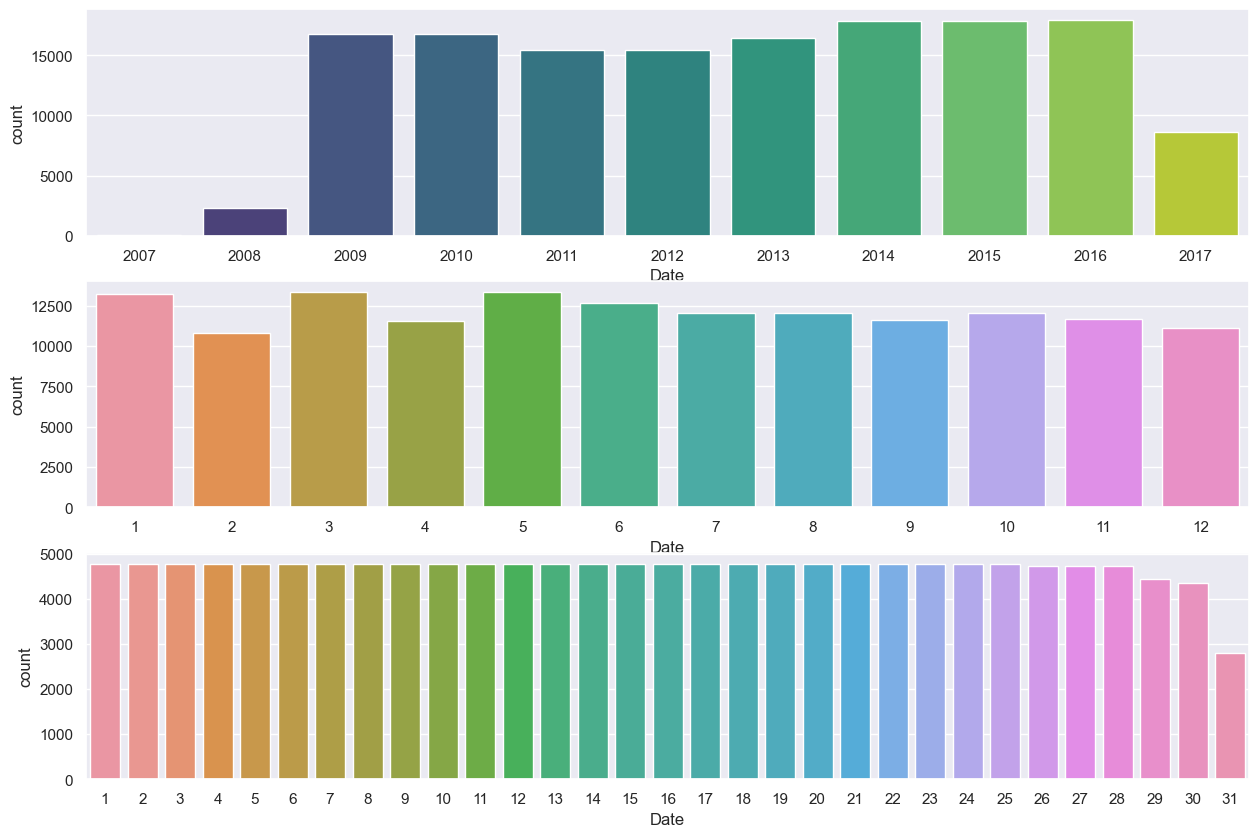

In [348]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10))
sns.countplot(ax=axes[0], x=pd.to_datetime(df.Date).dt.year, palette="viridis")
sns.countplot(ax=axes[1], x=pd.to_datetime(df.Date).dt.month)
sns.countplot(ax=axes[2], x=pd.to_datetime(df.Date).dt.day)
plt.show()

**Observaciones:**
* La variable Date la podemos descomponer en año, mes y día, es muy probable que solo nos interese estudiar solo la probabilidad de lluvia en cada uno de los meses.
* La distribución de datos de los años es bastante uniforme, salvo por el los dos primeros y el ultimo año que hay menos datos.
* La distribución del datos en los meses y días es uniforme.
* La variable Date nos puede traer un problema de alta cardinalidad, debemos evaluar la influencia del año y el mes para poder determinar si conviene o no incluir de forma separa mes y año.

### Cloud:
La variable Cloud solo posee 10 categórias correspondientes a la escala Octa utilizada para medir la nubosidad, en la cual 0 representa totalmente despejado y 9 totalmente nublado:

* 0 oktas represents the complete absence of cloud
* 1 okta represents a cloud amount of 1 eighth or less, but not zero
* 7 oktas represents a cloud amount of 7 eighths or more, but not full cloud cover
* 8 oktas represents full cloud cover with no breaks
* 9 oktas represents sky obscured by fog or other meteorological phenomena

https://es.wikipedia.org/wiki/Octa

In [349]:
df['Cloud9am'].value_counts(), df['Cloud3pm'].value_counts()

(7.0    19972
 1.0    15687
 8.0    14697
 0.0     8642
 6.0     8171
 2.0     6500
 3.0     5914
 5.0     5567
 4.0     4420
 9.0        2
 Name: Cloud9am, dtype: int64,
 7.0    18229
 1.0    14976
 8.0    12660
 6.0     8978
 2.0     7226
 3.0     6921
 5.0     6815
 4.0     5322
 0.0     4974
 9.0        1
 Name: Cloud3pm, dtype: int64)

**Observaciones:**
* Existen 10 categórias de nubosidad.

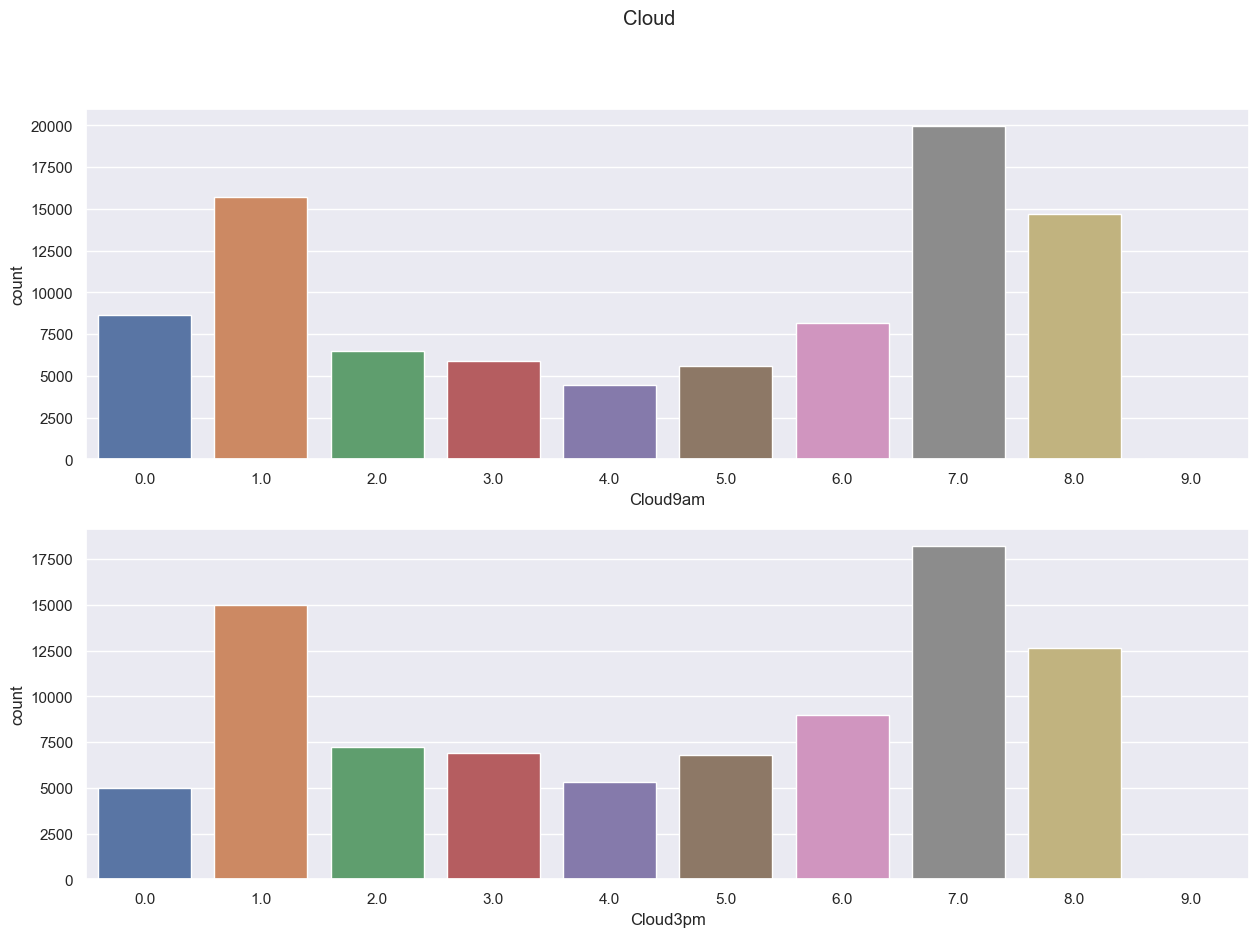

In [350]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
fig.suptitle('Cloud')
sns.countplot(ax=axes[0], x=df['Cloud9am'])
sns.countplot(ax=axes[1], x=df['Cloud3pm'])
plt.show()

### RainToday

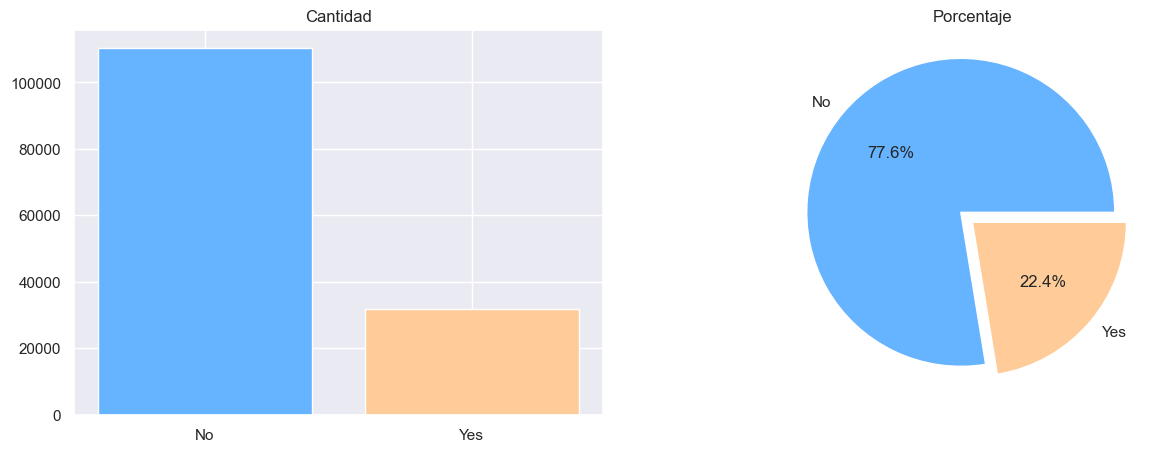

In [351]:
raintoday = df['RainToday'].value_counts()
raintoday_df = raintoday.to_frame().reset_index()
raintoday_df.columns = ["RainToday","porcentaje"]

fig = plt.figure(figsize=(15,5))

ax1=plt.subplot(121)
ax1.bar(raintoday_df["RainToday"], raintoday_df["porcentaje"], color=['#66b3ff','#ffcc99'])
ax1.set_title('Cantidad')

ax1=plt.subplot(122)
ax1.pie(raintoday.values/ len(df) * 100, explode=(0.1, 0),labels=raintoday.index, autopct='%1.1f%%', colors=['#66b3ff','#ffcc99'])
ax1.set_title('Porcentaje')
plt.show()

**Observaciones:**
* Se observa que el volumen de lluvía por año es bastante uniforme.
* Se observa que hay un relación significativa entre el mes y el volumen de lluvía promedio. Por ejemplo, el mes de febrero hay mayor cantidad de precipitación promedio.

In [ ]:
pd.to_datetime(df.Date)

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
sns.lineplot(ax=axes[0], x=pd.to_datetime(df.Date).dt.year, y=df.Rainfall)
sns.lineplot(ax=axes[1], x=pd.to_datetime(df.Date).dt.month, y=df.Rainfall)
plt.show()

## Análisis de variable categórica de salida:

### RainTomorrow:

In [ ]:
raintomorrow = df['RainTomorrow'].value_counts()
raintomorrow_df = raintomorrow.to_frame().reset_index()
raintomorrow_df.columns = ["RainTomorrow","porcentaje"]

fig = plt.figure(figsize=(15,5))

ax1=plt.subplot(121)
ax1.bar(raintomorrow_df["RainTomorrow"], raintomorrow_df["porcentaje"], color=['#66b3ff','#ffcc99'])
ax1.set_title('Cantidad')

ax1=plt.subplot(122)
ax1.pie(raintomorrow.values/ len(df) * 100, explode=(0.1, 0),labels=raintomorrow.index, autopct='%1.1f%%', colors=['#66b3ff','#ffcc99'])
ax1.set_title('Porcentaje')
raintomorrow_df
plt.show()

**Observaciones:**
* Las clases se encuentran desbalanceadas.

# 3. Limpieza y preparación de datos / ingeniería de features

## Análisis de faltantes:

In [296]:
df.isnull().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

**Se observa que hay 3267 registros en null en la variable de salida.**

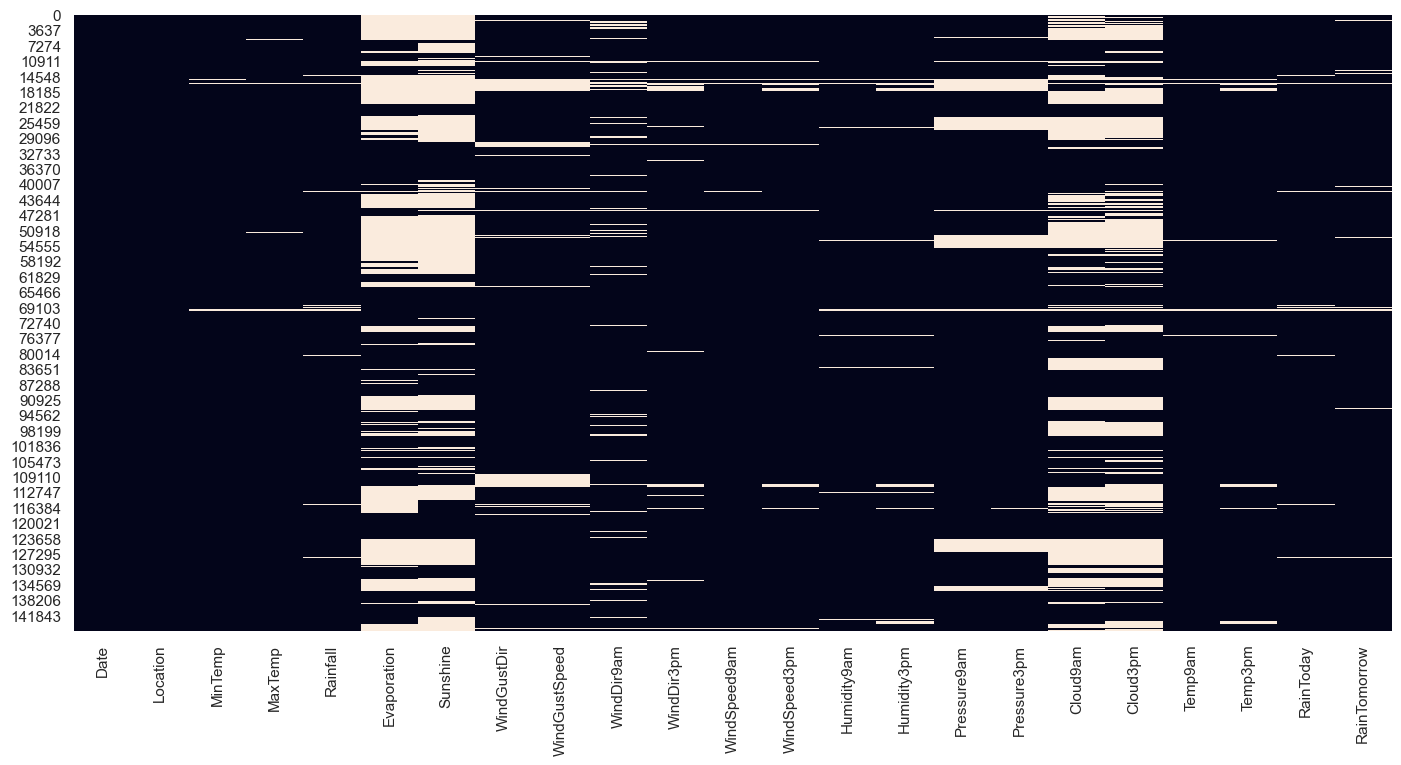

In [304]:
figure(figsize=(17,8))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

**Observaciones:**
* Se observa un gran número de faltantes en las columnas Evaporation, Sunshine, Cloud9am, Cloud3pm.
* Se observa que los faltantes coinciden en esas columnas, es probable que sean Missing not at Random ya que estos datos no hayan estado disponibles para determinadas localidades.

## Temperatura:

In [309]:
df[["MinTemp", "Temp9am", "MaxTemp", "Temp3pm"]].isnull().sum()

MinTemp    1485
Temp9am    1767
MaxTemp    1261
Temp3pm    3609
dtype: int64

### Sunshine:

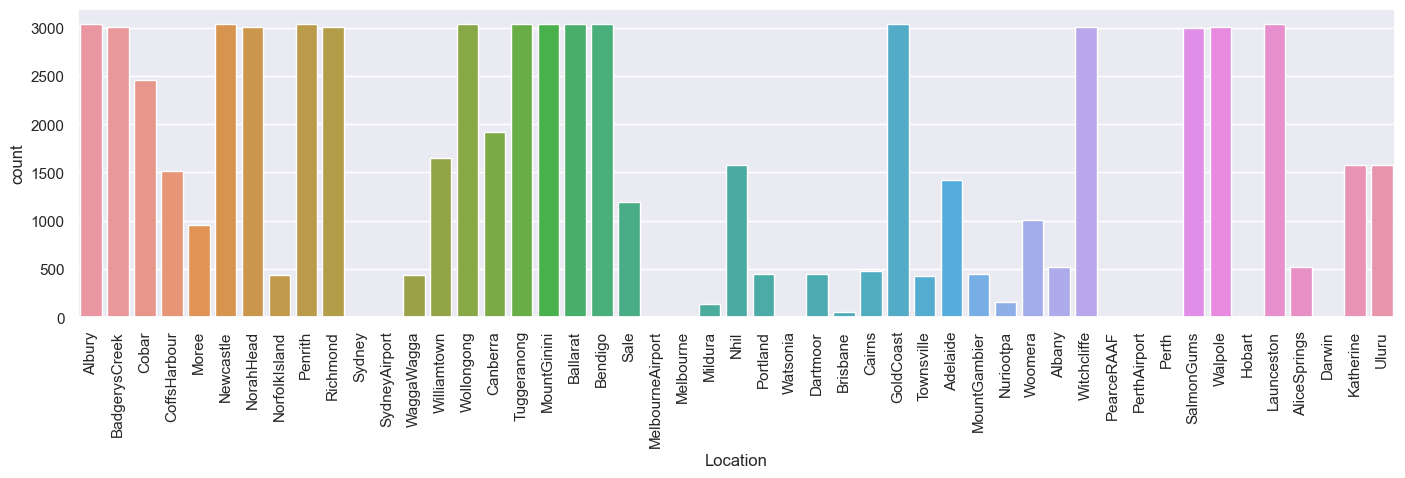

In [297]:
figure(figsize=(17,4))
plt.xticks(rotation=90)
sns.countplot(x=df[df['Sunshine'].isnull()]['Location'])
plt.show()

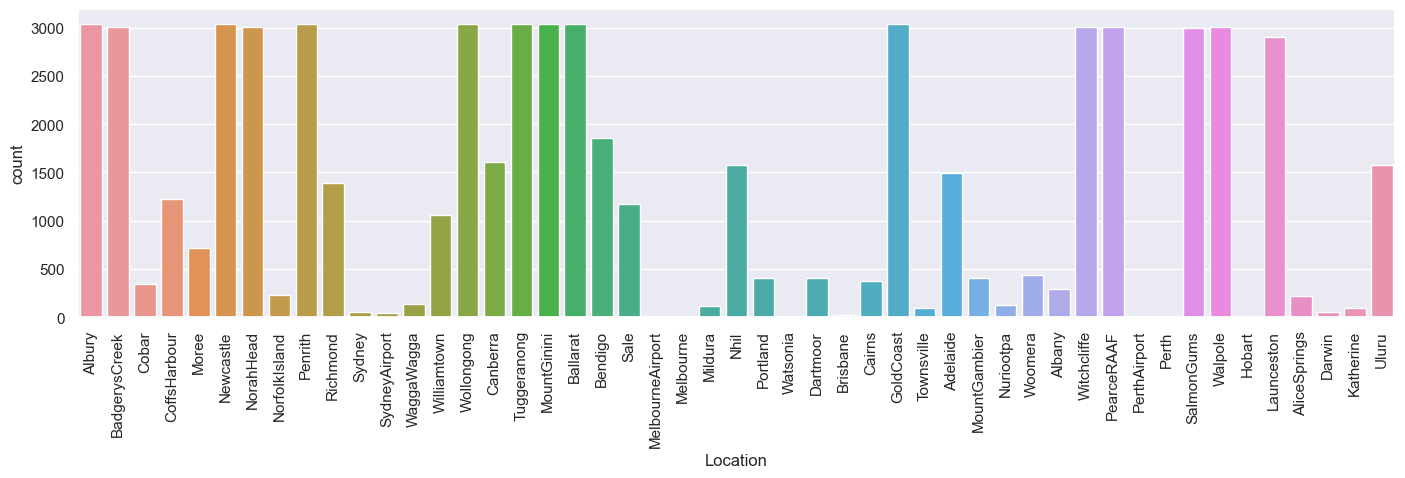

In [298]:
figure(figsize=(17,4))
plt.xticks(rotation=90)
sns.countplot(x=df[df['Evaporation'].isnull()]['Location'])
plt.show()

**Observaciones:**
* Se observa que en algunas localidades no se realizaron mediciones de la variable Sunshine y Evaporation.

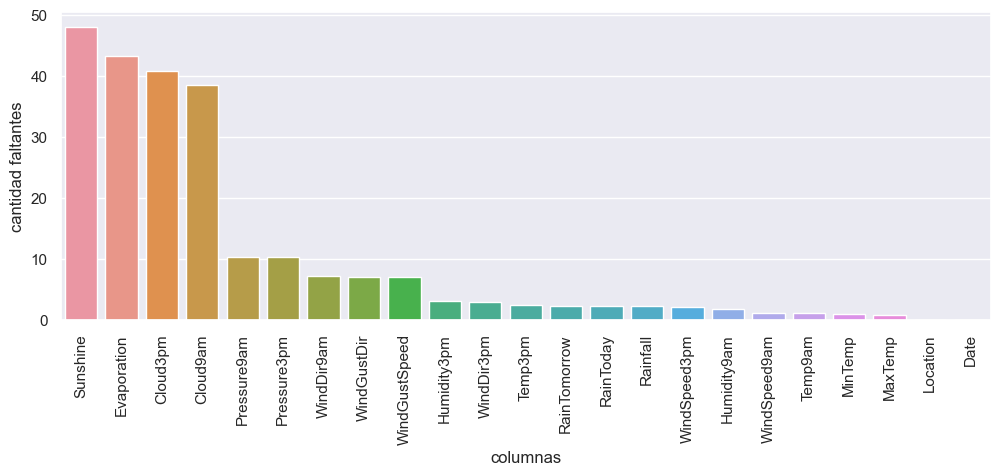

In [299]:
# Verificamos valores faltantes
faltantes = np.sum(df.isnull()/len(df)*100).sort_values(ascending=False)
faltantes_df = faltantes.to_frame().reset_index()
faltantes_df.columns = ["columnas","cantidad faltantes"]
figure(figsize=(12,4))
plt.xticks(rotation=90)
ax = sns.barplot(x="columnas", y="cantidad faltantes", data=faltantes_df)
plt.show()

### Observaciones:
* La columna "Sunshine" es la características que posee mayor cantidad de faltantes.
* Las columnas "Sunshine", "Evaporation", "Cloud3pm" y "Cloud9am" son las que mayor número de faltantes posee.
* El resto de las columnas posee un número de faltantes por debajo al 10%.
* Las columnas "Dates" y "Location" no poseen nulos.
* La variable "RainToday" posse 3261 valores nulos.


### Faltantes:

In [300]:
# Verificamos valores faltantes de las variables categoricas
faltantes_cat = np.sum(df[["Location", "WindGustDir", "WindDir9am", "WindDir3pm", "RainToday", "RainTomorrow", "Date"]].isnull()).sort_values(ascending=False)
faltantes_cat

WindDir9am      10566
WindGustDir     10326
WindDir3pm       4228
RainTomorrow     3267
RainToday        3261
Date                0
Location            0
dtype: int64

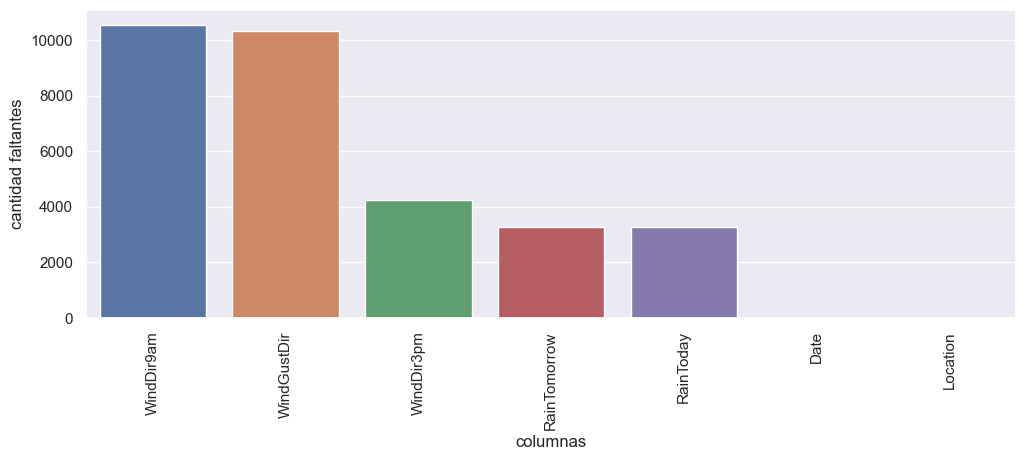

In [301]:
faltantes_cat_df = faltantes_cat.to_frame().reset_index()
faltantes_cat_df.columns = ["columnas","cantidad faltantes"]
figure(figsize=(12,4))
plt.xticks(rotation=90)
ax = sns.barplot(x="columnas", y="cantidad faltantes", data=faltantes_cat_df)
plt.show()

In [225]:
X = df_aux[['MinTemp','MaxTemp','Rainfall','Evaporation','Sunshine','WindSpeed9am','WindSpeed3pm','Humidity9am','Humidity3pm','Pressure9am','Pressure3pm','Cloud9am','Cloud3pm','Temp9am','Temp3pm']].values[:, :-1]
y = df_aux.values[:, -1]

In [226]:
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ( 'imputer' ,SimpleImputer()), 
    ( 'lr' , LogisticRegression() )
])

param_grid = {
    "imputer__strategy": ['most_frequent', 'mean','constant','median' ],
    "lr__max_iter": [1000]
}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
search = GridSearchCV(estimator=pipeline,param_grid=param_grid,cv=cv)
results =search.fit(X,y)

In [227]:
print('Mejor Puntaje (Accuracy): %.3f ' % results.best_score_)
print('Mejor parámetro: %s ' % results.best_params_)

Mejor Puntaje (Accuracy): 0.835 
Mejor parámetro: {'imputer__strategy': 'median', 'lr__max_iter': 1000} 


In [ ]:
from sklearn.model_selection import cross_val_score

results=[]
for param in param_grid["imputer__strategy"]:
    pipeline = Pipeline(steps=[
        ( 'imputer' ,SimpleImputer(strategy=param)), 
        ( 'lr' , LogisticRegression(max_iter=1000) )
    ])
    
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring= 'accuracy' , cv=cv, n_jobs=-1)    
    results.append(scores)

In [ ]:
fig,axes = plt.subplots(1,figsize=(14,6))
axes.boxplot(results,labels=param_grid["imputer__strategy"],showmeans=True)
axes.set_xlabel("Método")
axes.set_ylabel("Accuracy")
axes.set_title("Efecto de métodos de imputación estadística en Regresión Logística");
plt.show()

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

results=[]

param_grid = {
    "imputer__n_nearest_features": [None,1,2,3]
}

for param in param_grid["imputer__n_nearest_features"]:
    pipeline = Pipeline(steps=[
        ( 'imputer' ,IterativeImputer(n_nearest_features=param)), 
        ( 'lr' , LogisticRegression(max_iter=1000) )
    ])
    
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)
    scores = cross_val_score(pipeline, X, y, scoring= 'accuracy' , cv=cv, n_jobs=-1)    
    results.append(scores)
    
fig,axes = plt.subplots(1,figsize=(14,6))
axes.boxplot(results,labels=
    [x or "None" for x in param_grid["imputer__n_nearest_features"]],showmeans=True)
axes.set_xlabel("n_nearest_features")
axes.set_ylabel("Accuracy")
axes.set_title("MICE (IterativeImputer) en Titanic");   

In [ ]:
plt.show()

In [ ]:
from sklearn import linear_model
clf = linear_model.BayesianRidge()
imp = IterativeImputer(estimator=clf, verbose=2, max_iter=1000, tol=1e-6)

In [ ]:
Z = imp.fit_transform(X)

In [ ]:
Z = pd.DataFrame(Z)

In [ ]:
X.loc[0]

In [ ]:
indice = X.index

In [ ]:
indice.get_loc(0)

In [ ]:
X.iloc[0]

In [ ]:
Z.iloc[0]

In [ ]:
from sklearn import linear_model
clf = LinearRegression()
imp = IterativeImputer(estimator=clf, verbose=2, max_iter=1000, tol=1e-6)

In [ ]:
G = imp.fit_transform(X)

In [ ]:
# Se eliminan los datos faltantes en la variable de salida.
df = df[df['RainTomorrow'].notna()]
df.isnull().sum()

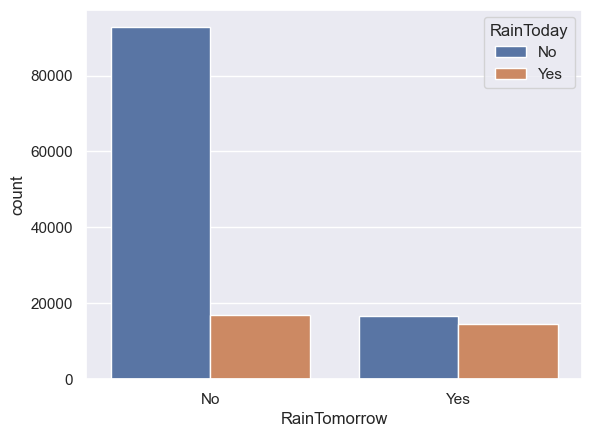

In [319]:
fig.suptitle('Cloud')
sns.countplot(x="RainTomorrow", hue="RainToday", data=df)
plt.show()